<a href="https://colab.research.google.com/github/ipeirotis/autoencoders_census/blob/main/measure_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Autoencoders and Data Quality for Tabular Data**

In [1]:
!rm -rf autoencoders_census
!git clone https://github.com/ipeirotis/autoencoders_census.git
%cd autoencoders_census

Cloning into 'autoencoders_census'...
remote: Enumerating objects: 391, done.
remote: Counting objects: 100% (268/268), done.
remote: Compressing objects: 100% (196/196), done.
remote: Total 391 (delta 159), reused 123 (delta 72), pack-reused 123
Receiving objects: 100% (391/391), 42.31 MiB | 7.45 MiB/s, done.
Resolving deltas: 100% (225/225), done.
Updating files: 100% (12/12), done.
/content/autoencoders_census


In [2]:
from google.colab import auth

# Login using the account that has access to the Google project
# in order to access the resources for the project
auth.authenticate_user()

In [3]:
# This code imports the DataTransformer object from
# the notebook pandas2vector.ipynb
!pip install -q import_ipynb keras-tuner
import import_ipynb
from pandas2vector import Table2Vector
from data_loader import DataLoader
from autoencoder import AutoencoderModel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.9 MB/s eta 0:00:00
importing Jupyter notebook from pandas2vector.ipynb
importing Jupyter notebook from data_loader.ipynb
importing Jupyter notebook from autoencoder.ipynb


# Data Source

The used data stems from the Youth Risk Behavior Surveillance System by CDC (Centers for Disease Control and Prevention). It includes data on a set of surveys that track behaviors that can lead to poor health in students grades 9 through 12. [Here](https://www.cdc.gov/healthyyouth/data/yrbs/data.htm) is the link to the dataset.

Note: The dataset is updated every two years. We use the 2017 version of the national high school YRBS dataset.

## Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from pandas.api.types import is_numeric_dtype
from matplotlib.offsetbox import TransformedBbox

In [6]:
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.interpolate import interp1d
from numpy.random import uniform
from numpy.random import seed

In [7]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras import backend as K
from keras import Model

In [8]:
import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow import keras

# Load Original Dataset

In [9]:

# Data Source
data_loader = DataLoader()

project_data, variable_types  = data_loader.load_2017()



In [10]:
project_data.shape

(14765, 98)

In [11]:
project_data.dropna().shape

(14765, 98)

# Vectorizing the data set

In [12]:
# Data Transformation
vectorizer = Table2Vector(variable_types)


# Without indicator variables for missingness
vectorized_df = vectorizer.vectorize_table(project_data)

In [13]:
assert( vectorizer.tabularize_vector(vectorized_df).shape == project_data.shape )

# Autoencoder loading

In [14]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope
import gcsfs




# Define the path to the file on GCS
gcs_model_path = "gs://autoencoder_census_models/best_parameters_autoencoder.h5"

# Define the local path where the model will be downloaded
local_model_path = "best_parameters_autoencoder.h5"

# Create a GCS filesystem object using your project ID
fs = gcsfs.GCSFileSystem(project='autoencoder-census')

# Download the model file from GCS
with fs.open(gcs_model_path, 'rb') as gcs_file:
    with open(local_model_path, 'wb') as local_file:
        local_file.write(gcs_file.read())


# Initialize AutoencoderModel with attribute_cardinalities
# to use the custom loss function
attr_cardinalities = list(project_data.describe().T['unique'].values)
autoencoder_model = AutoencoderModel(attr_cardinalities)


# Load the model from the local file
with custom_object_scope({'custom_categorical_crossentropy': autoencoder_model.custom_categorical_crossentropy}):
  model = load_model(local_model_path)




## Making Predictions and Filling in the Missing Values


In [15]:
import numpy as np

# Fill the missing values with some initial guess. Here, the median of each column is used.
filled = vectorized_df.fillna(vectorized_df.median())

# Define a condition for stopping the iteration
epsilon = 1e-5
old_filled = None

while old_filled is None or np.abs(filled - old_filled).sum().sum() > epsilon:
  # Save the old filled DataFrame for convergence check
  old_filled = filled.copy()

  # Run the data through the autoencoder, which will return a complete version of the data.
  predicted = model.predict(filled)

  # Replace the initially guessed values in the original data with the corresponding values from the autoencoder's output. But keep the observed values unchanged.
  mask = vectorized_df.isna()
  filled[mask] = np.where(mask, predicted, filled)


462/462 [==============================] - 7s 7ms/step


In [16]:
filled

age__12 years old or younger  age__13 years old  age__14 years old  \
0                               0.0                0.0                0.0   
1                               0.0                0.0                0.0   
2                               0.0                0.0                0.0   
3                               0.0                0.0                0.0   
4                               0.0                0.0                0.0   
...                             ...                ...                ...   
14760                           0.0                0.0                0.0   
14761                           0.0                0.0                0.0   
14762                           0.0                0.0                0.0   
14763                           0.0                0.0                0.0   
14764                           0.0                0.0                0.0   

       age__15 years old  age__16 years old  age__17 years old  \
0                    0.0                0.0                0.0   
1                    0.0                0.0                0.0   
2                    0.0                0.0                0.0   
3                    0.0                0.0                0.0   
4                    0.0                0.0                0.0   
...                  ...                ...                ...   
14760                0.0                0.0                0.0   
14761                0.0                0.0                0.0   
14762                0.0                0.0                0.0   
14763                0.0                0.0                0.0   
14764                0.0                0.0                0.0   

       age__18 years old or older  age__nan  sex__Female  sex__Male  ...  \
0                             0.0       1.0          0.0        0.0  ...   
1                             0.0       1.0          0.0        0.0  ...   
2                             0.0       1.0          0.0        0.0  ...   
3                             0.0       1.0          0.0        0.0  ...   
4                             0.0       1.0          0.0        0.0  ...   
...                           ...       ...          ...        ...  ...   
14760                         1.0       0.0          1.0        0.0  ...   
14761                         1.0       0.0          1.0        0.0  ...   
14762                         1.0       0.0          1.0        0.0  ...   
14763                         1.0       0.0          1.0        0.0  ...   
14764                         1.0       0.0          1.0        0.0  ...   

       stheight_cat__top-extreme%  stweight_cat__missing  \
0                             0.0                    1.0   
1                             0.0                    1.0   
2                             0.0                    1.0   
3                             0.0                    1.0   
4                             0.0                    1.0   
...                           ...                    ...   
14760                         0.0                    1.0   
14761                         0.0                    1.0   
14762                         0.0                    1.0   
14763                         0.0                    0.0   
14764                         0.0                    1.0   

       stweight_cat__normal  stweight_cat__top-extreme%  \
0                       0.0                         0.0   
1                       0.0                         0.0   
2                       0.0                         0.0   
3                       0.0                         0.0   
4                       0.0                         0.0   
...                     ...                         ...   
14760                   0.0                         0.0   
14761                   0.0                         0.0   
14762                   0.0                         0.0   
14763                   1.0                         0.0   
14764 

Now that we have filled in the original dataset with the most likely values for their missing values, we run the Autoencoder on the filled vectorized dataset.

In [17]:
predicted = pd.DataFrame(model.predict(filled))
predicted.columns = filled.columns
predicted

462/462 [==============================] - 3s 5ms/step


age__12 years old or younger  age__13 years old  age__14 years old  \
0                          0.008854           0.000914           0.053996   
1                          0.012965           0.002962           0.159671   
2                          0.016545           0.001026           0.051786   
3                          0.022097           0.000936           0.042158   
4                          0.009249           0.006250           0.255473   
...                             ...                ...                ...   
14760                      0.440979           0.002338           0.029040   
14761                      0.419166           0.003395           0.034914   
14762                      0.377622           0.002574           0.039877   
14763                      0.005556           0.002863           0.163504   
14764                      0.271543           0.004376           0.067406   

       age__15 years old  age__16 years old  age__17 years old  \
0               0.170452           0.253586           0.304417   
1               0.259041           0.247787           0.181032   
2               0.151486           0.251950           0.295202   
3               0.132901           0.240201           0.303495   
4               0.321879           0.192143           0.124668   
...                  ...                ...                ...   
14760           0.086511           0.098537           0.184884   
14761           0.091447           0.105248           0.211215   
14762           0.108457           0.111794           0.207346   
14763           0.245987           0.257230           0.264514   
14764           0.149537           0.135463           0.217196   

       age__18 years old or older  age__nan  sex__Female  sex__Male  ...  \
0                        0.168781  0.039001     0.470622   0.462397  ...   
1                        0.101714  0.034827     0.623683   0.315528  ...   
2                        0.175920  0.056084     0.519820   0.391533  ...   
3                        0.187389  0.070823     0.486585   0.405377  ...   
4                        0.069279  0.021059     0.487928   0.479467  ...   
...                           ...       ...          ...        ...  ...   
14760                    0.106180  0.051531     0.200075   0.566763  ...   
14761                    0.088094  0.046521     0.194265   0.507922  ...   
14762                    0.116109  0.036221     0.180140   0.658709  ...   
14763                    0.058919  0.001427     0.560637   0.435741  ...   
14764                    0.106567  0.047912     0.273795   0.506265  ...   

       stheight_cat__top-extreme%  stweight_cat__missing  \
0                        0.000246               0.959625   
1                        0.000220               0.955455   
2                        0.000083               0.992081   
3                        0.000047               0.996512   
4                        0.000526               0.872751   
...                           ...                    ...   
14760                    0.000236               0.994159   
14761                    0.000160               0.996363   
14762                    0.000993               0.972230   
14763                    0.000623               0.004186   
14764                    0.000380               0.984492   

       stweight_cat__normal  stweight_cat__top-extreme%  \
0                  0.035834                    0.004541   
1                  0.040486                    0.004058   
2                  0.006649                    0.001269   
3                  0.002858                    0.000630   
4                  0.121860                    0.005389   
...                     ...                         ...   
14760              0.004860                    0.000980   
14761              0.002976                    0.000661   
14762              0.023858                    0.003912   
14763              0.981111                    0.014703   
14764 

In [18]:
tabular_from_predicted = vectorizer.tabularize_vector(predicted)

## Visualization of the original vs reconstructed

In [19]:
import matplotlib.pyplot as plt

def create_scatterplot_for_numeric(original_df, predicted_df, numeric_attr):
  plt.figure(figsize=(10, 6))  # Create a new figure with a particular size
  plt.scatter(original_df[numeric_attr], predicted_df[numeric_attr], s=1)  # Create a scatterplot
  plt.xlabel(f'Original Data ({numeric_attr})')  # Set the x-axis label
  plt.ylabel(f'Reconstructed Data ({numeric_attr})')  # Set the y-axis label
  plt.title(f'Scatterplot for {numeric_attr}')  # Set the plot title
  plt.show()  # Display the plot

for v in variable_types.keys():
  if variable_types[v] == 'numeric':
    print(v)
    create_scatterplot_for_numeric(project_data, tabular_from_predicted, v)



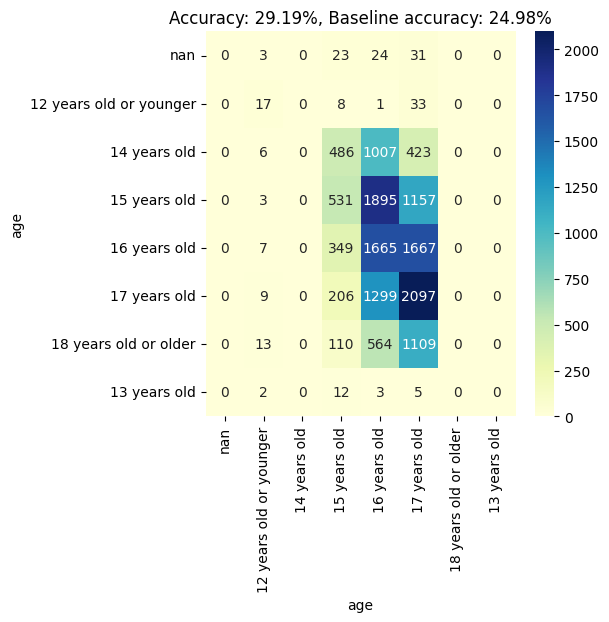

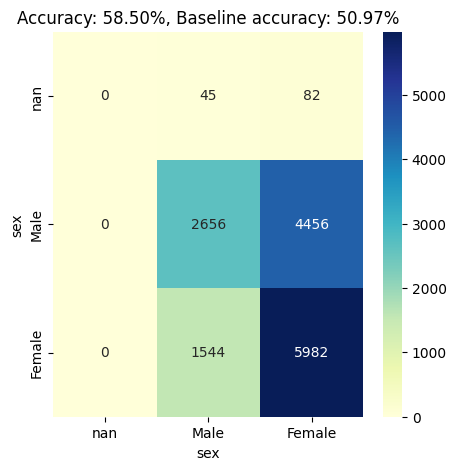

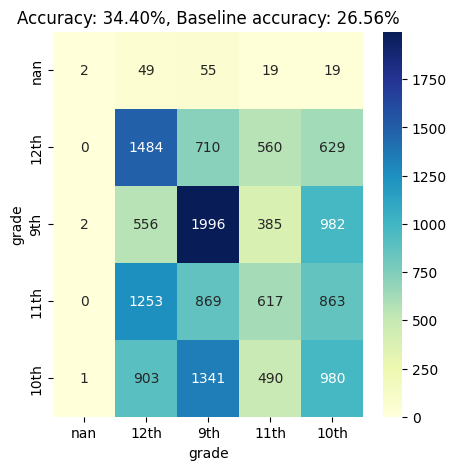

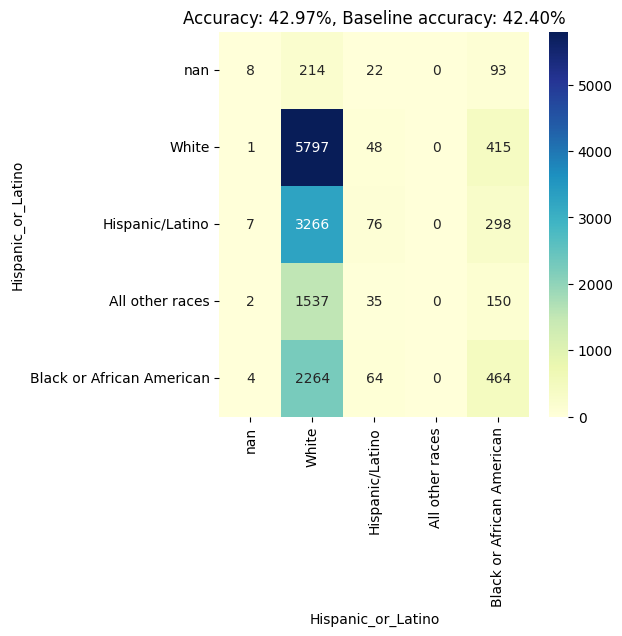

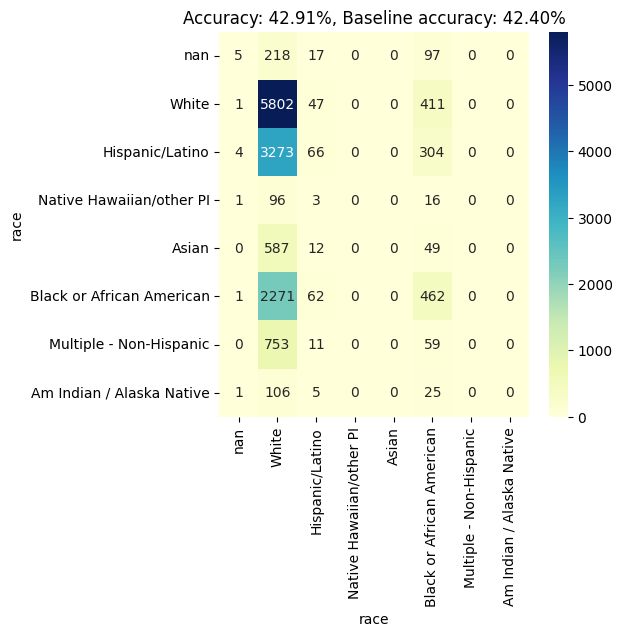

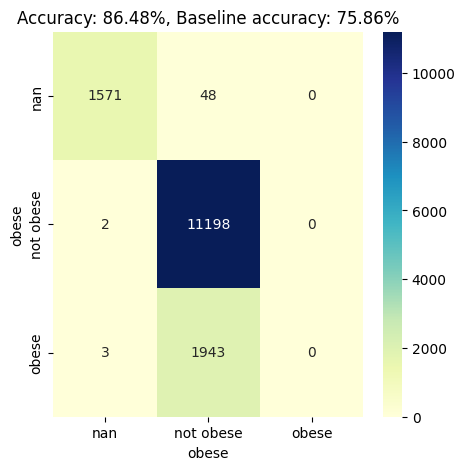

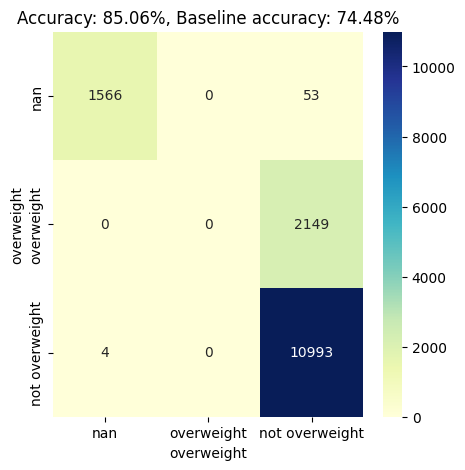

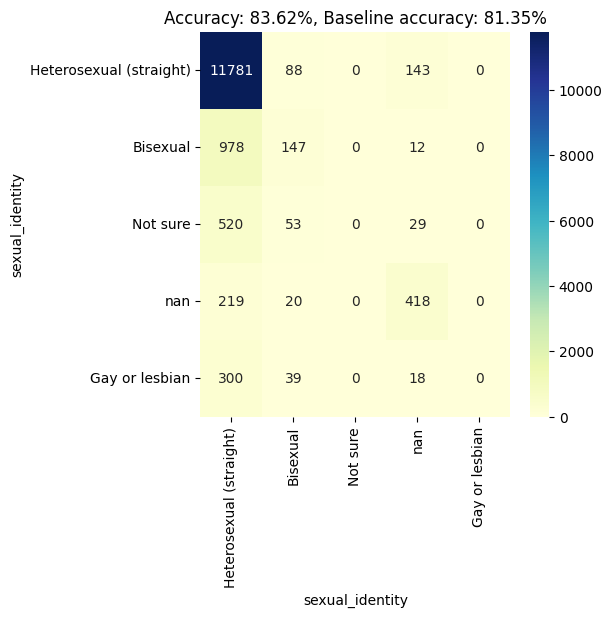

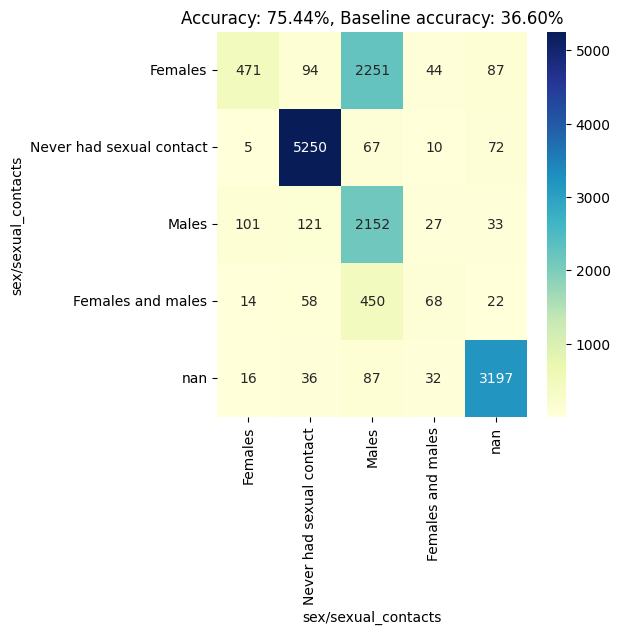

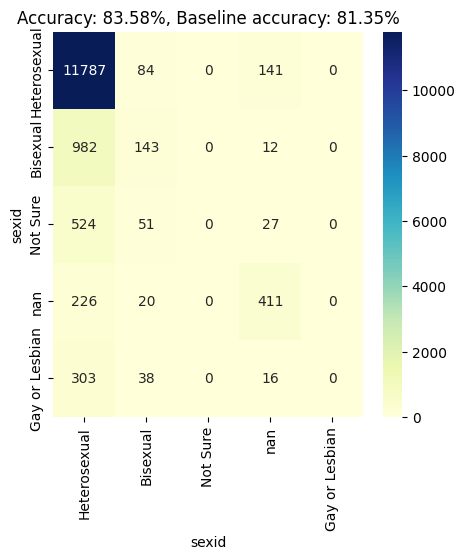

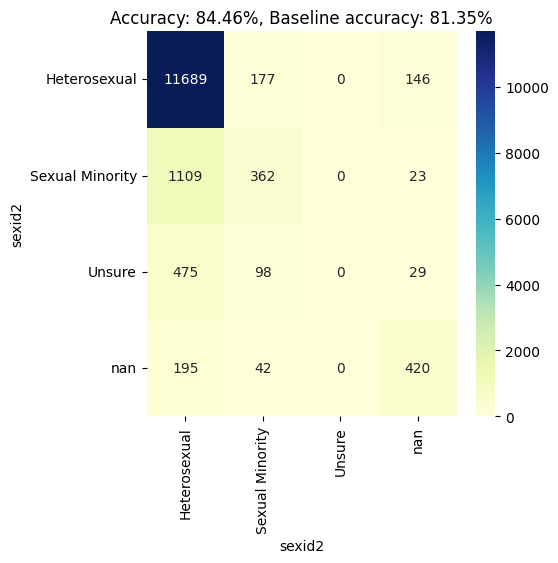

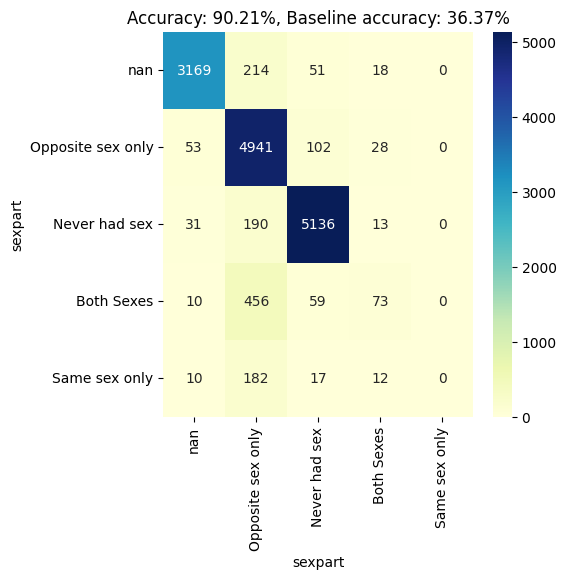

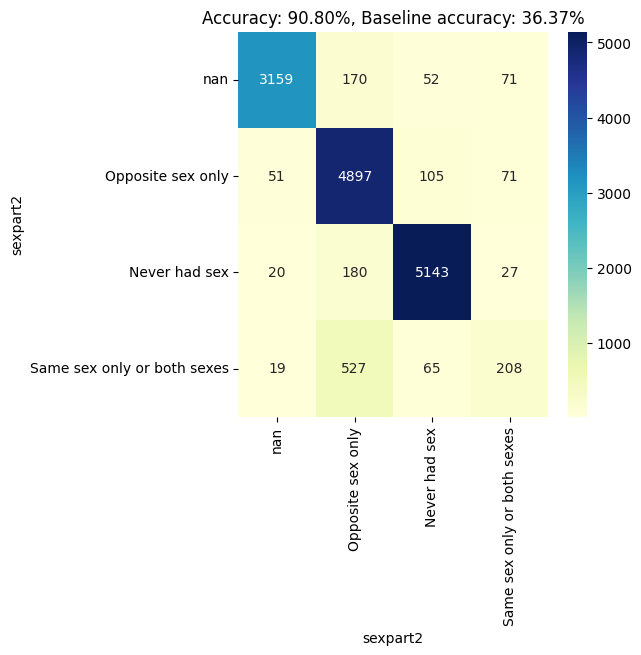

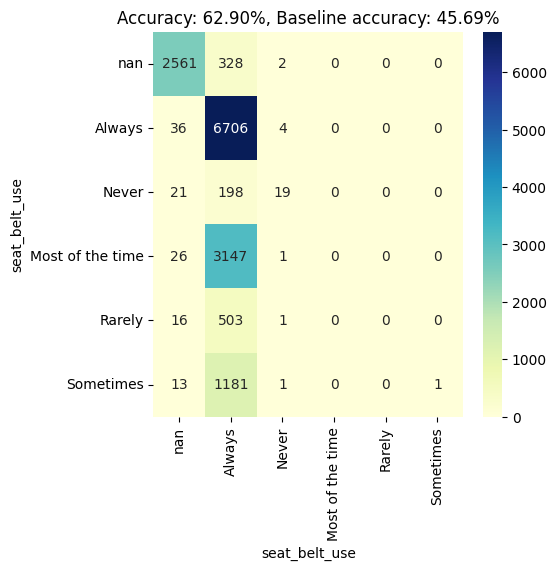

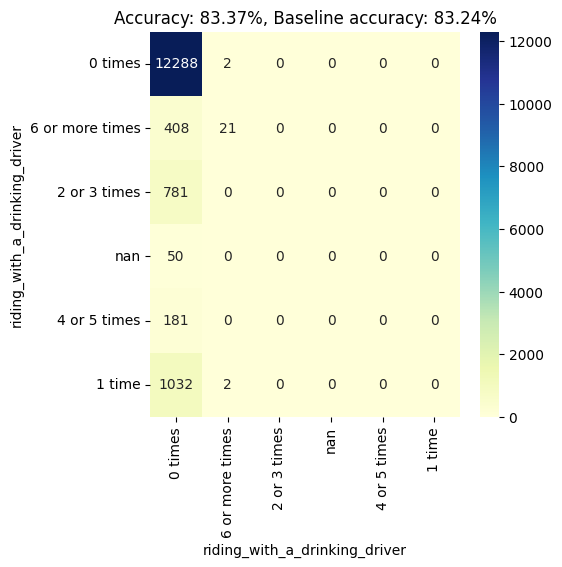

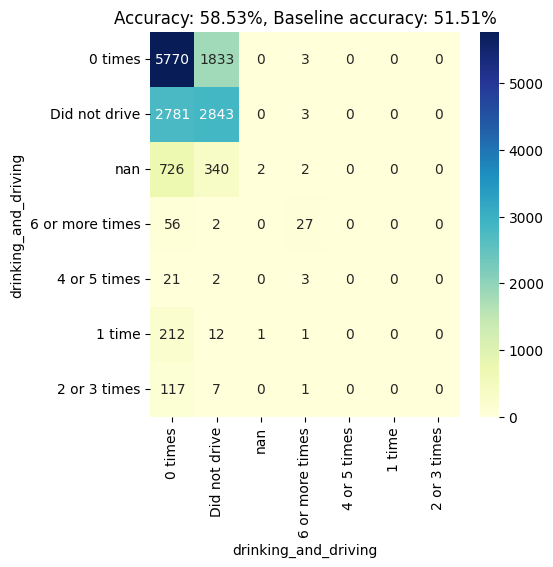

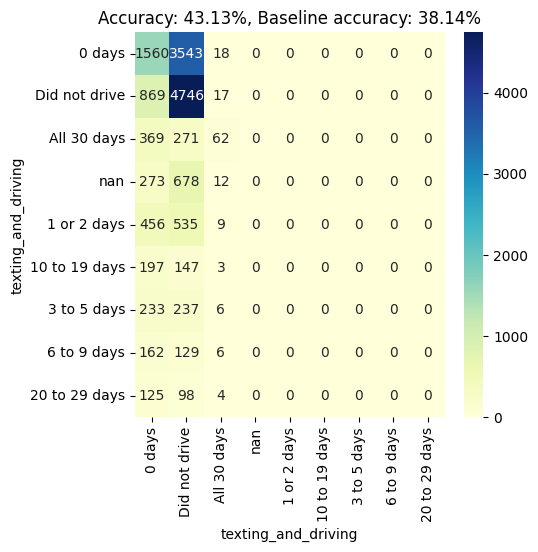

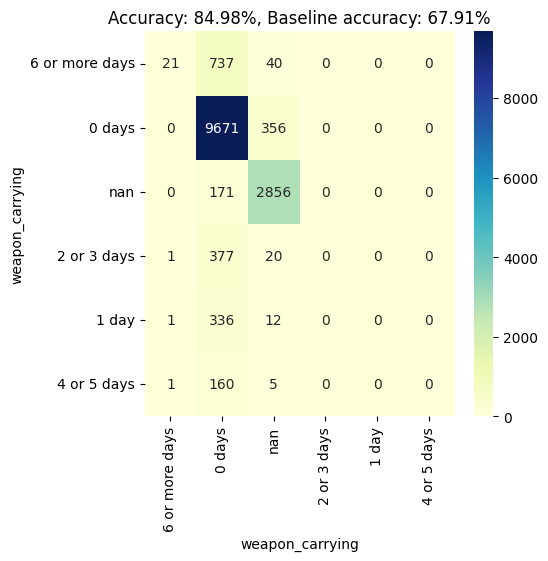

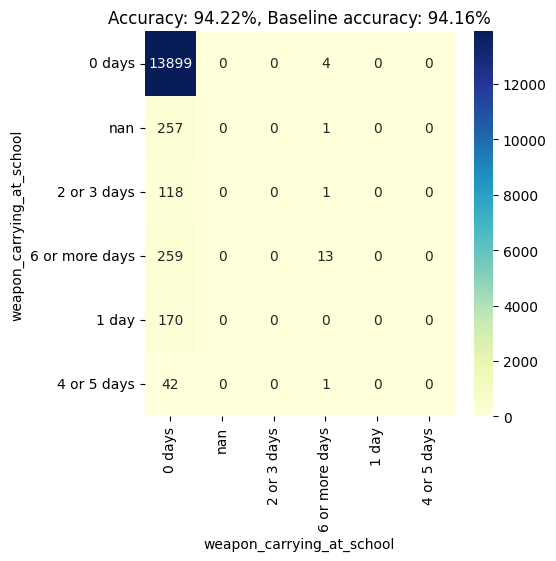

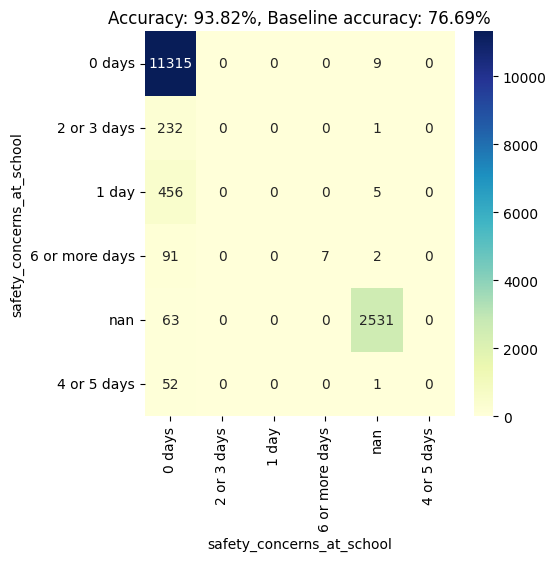

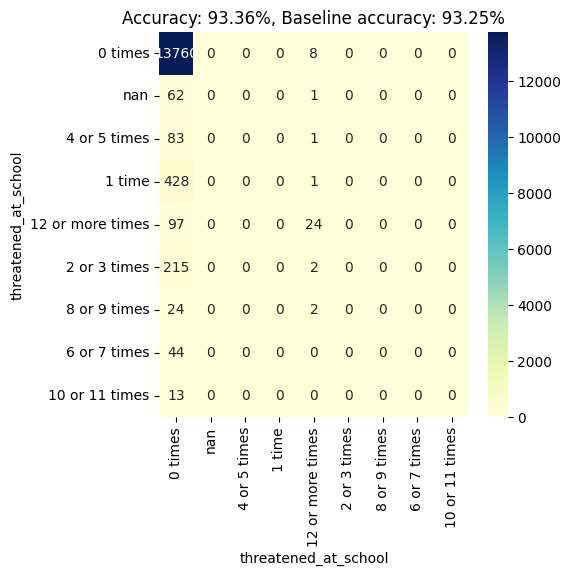

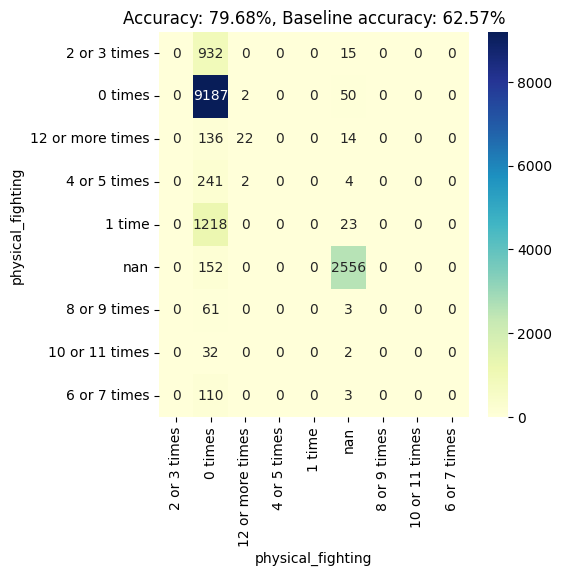

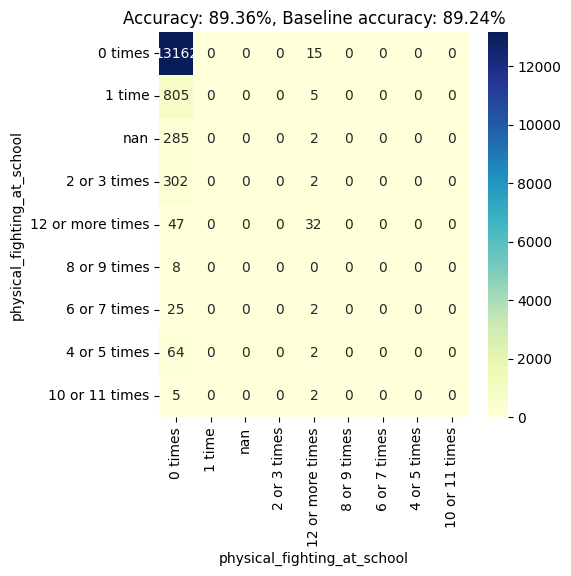

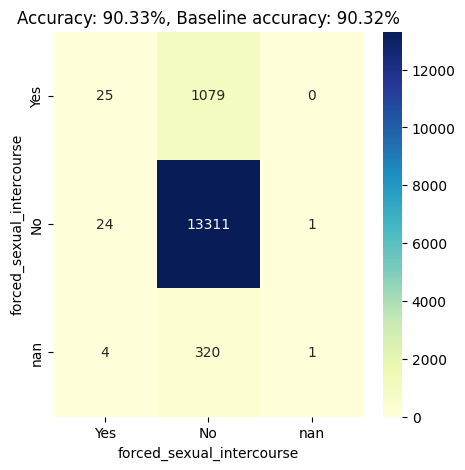

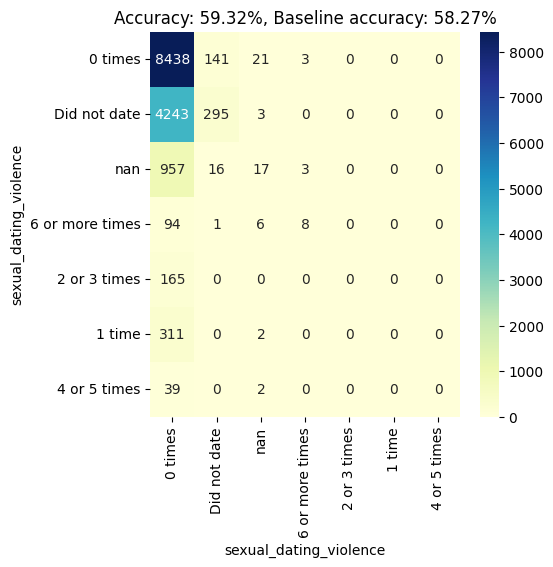

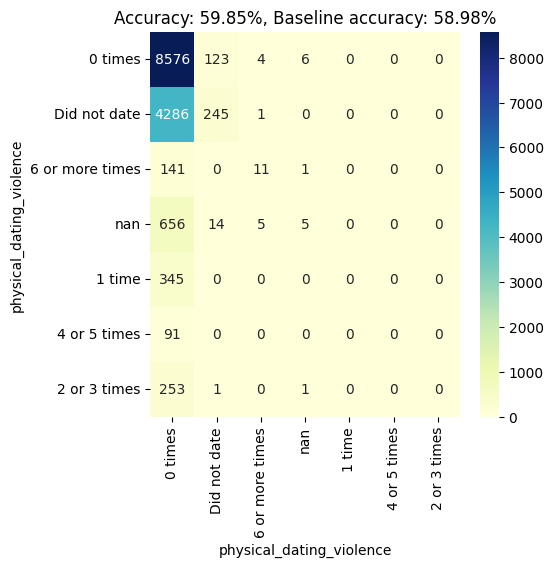

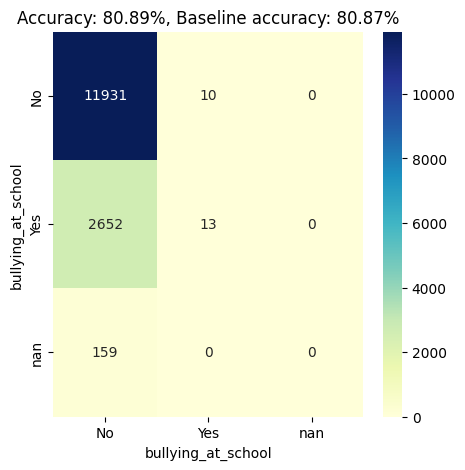

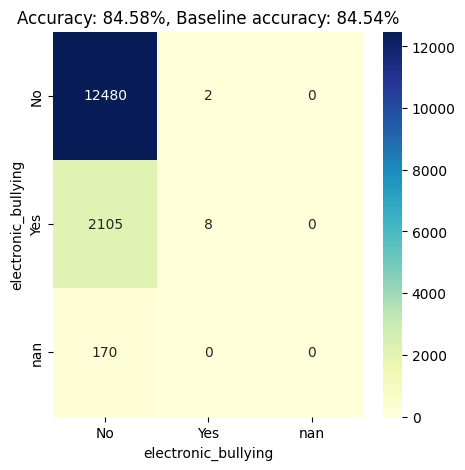

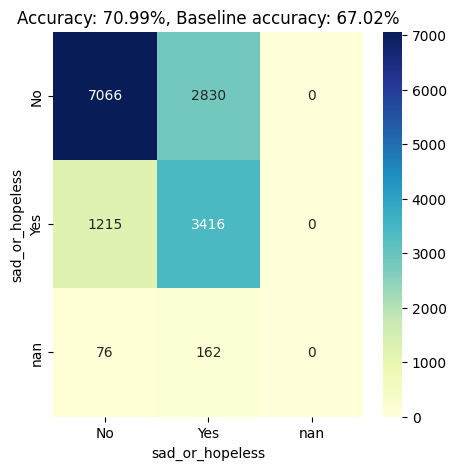

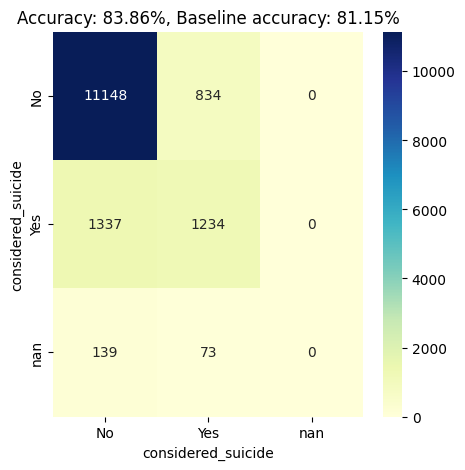

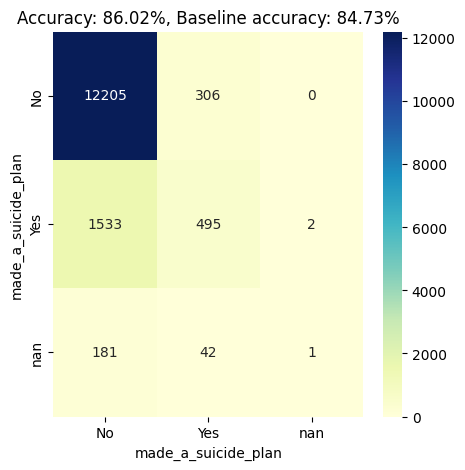

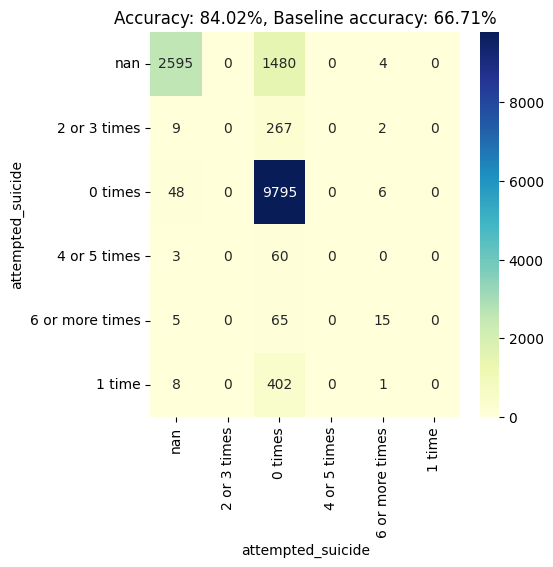

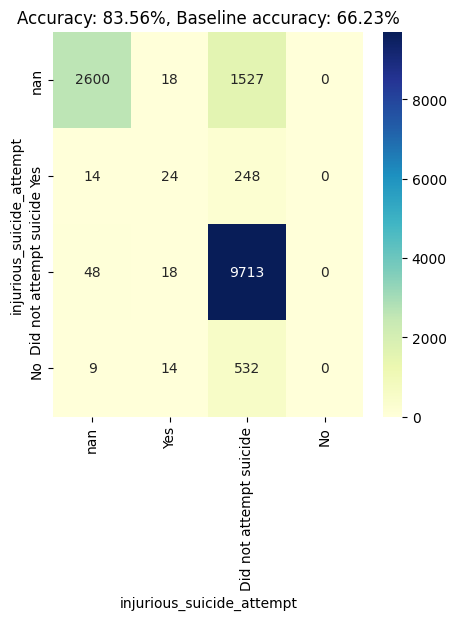

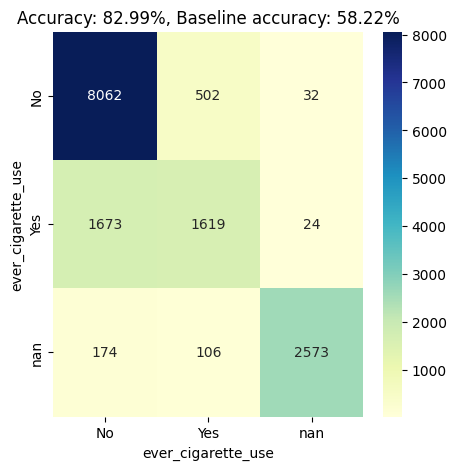

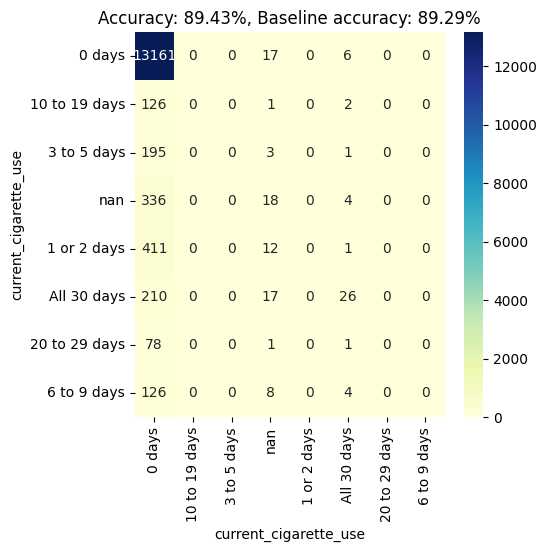

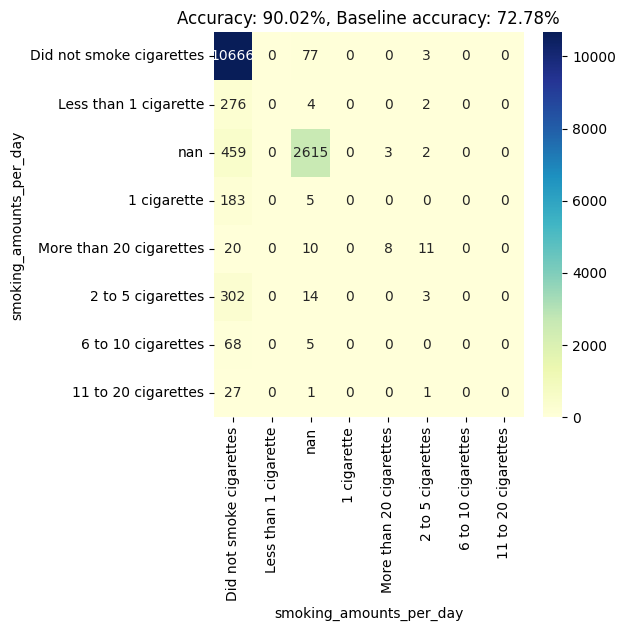

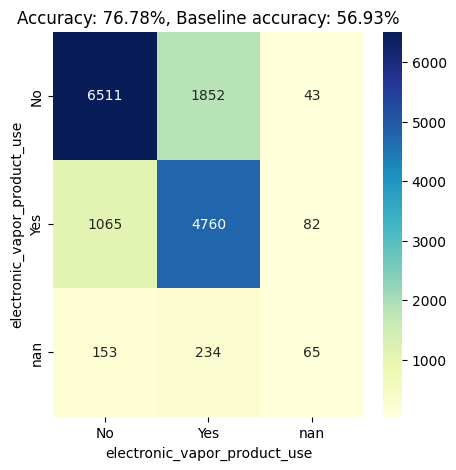

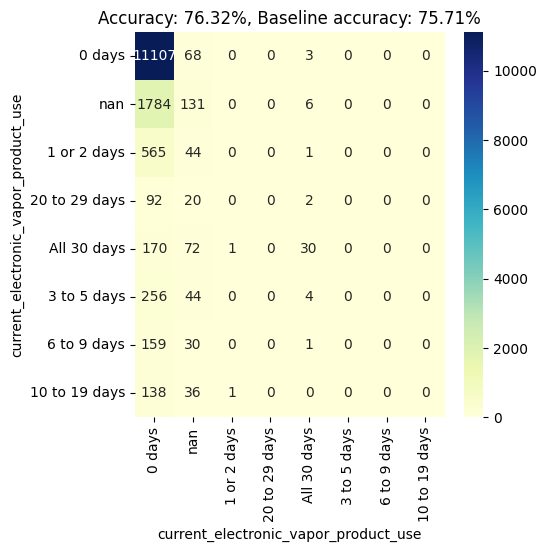

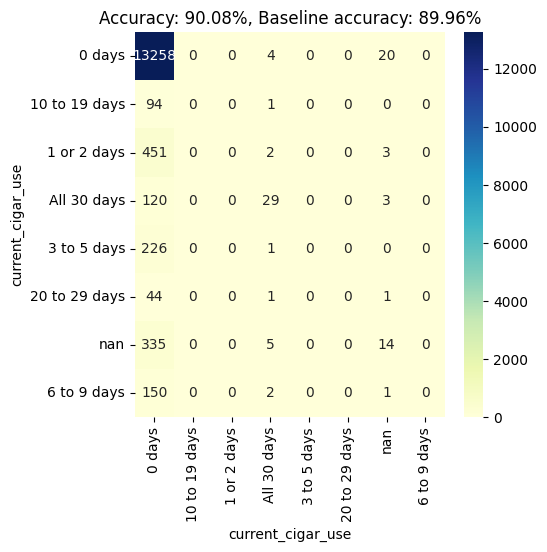

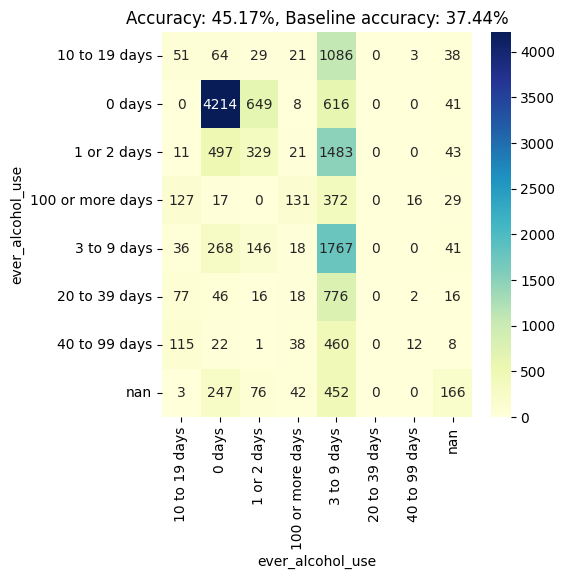

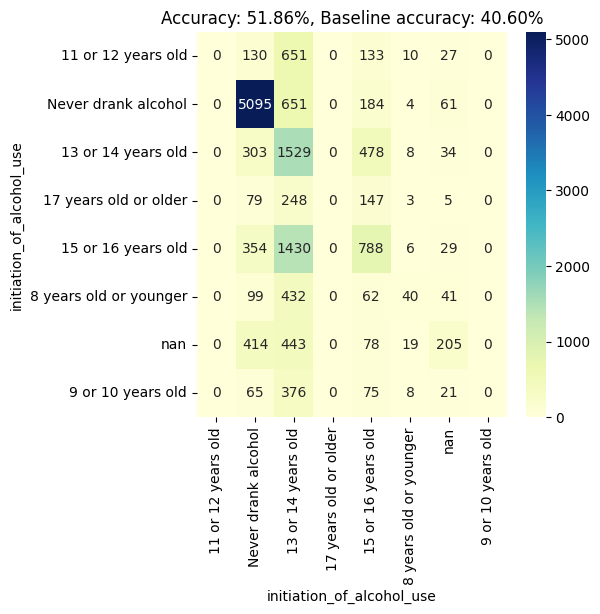

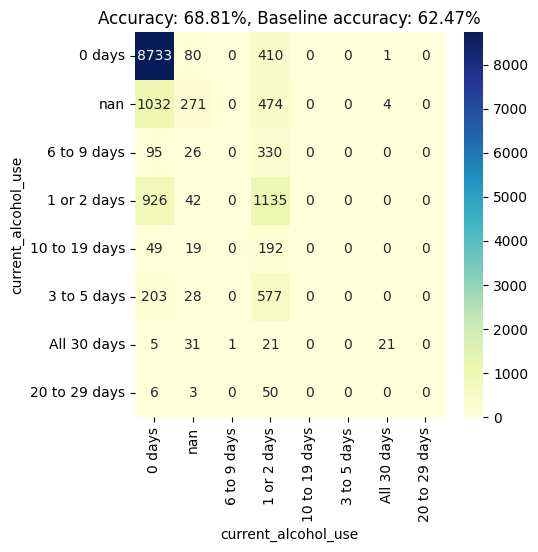

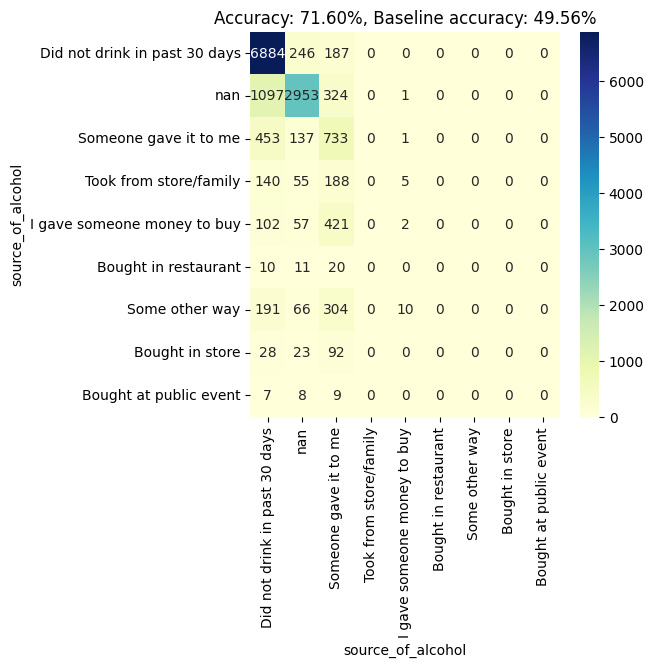

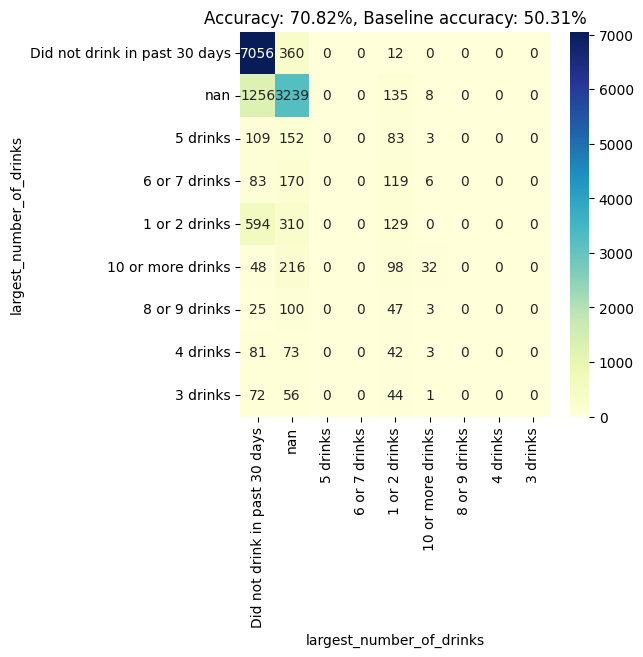

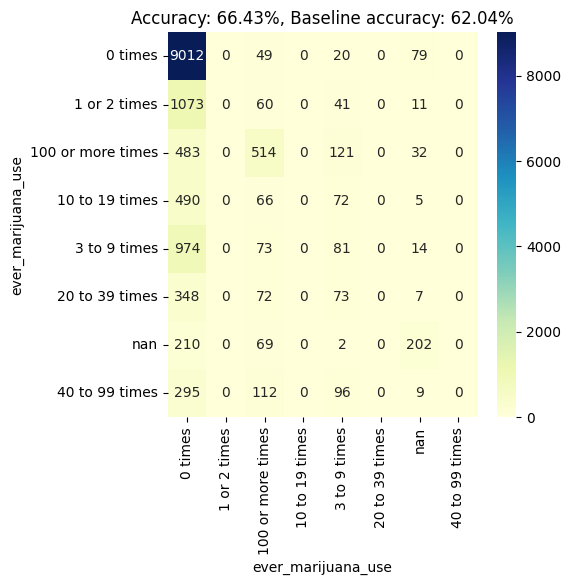

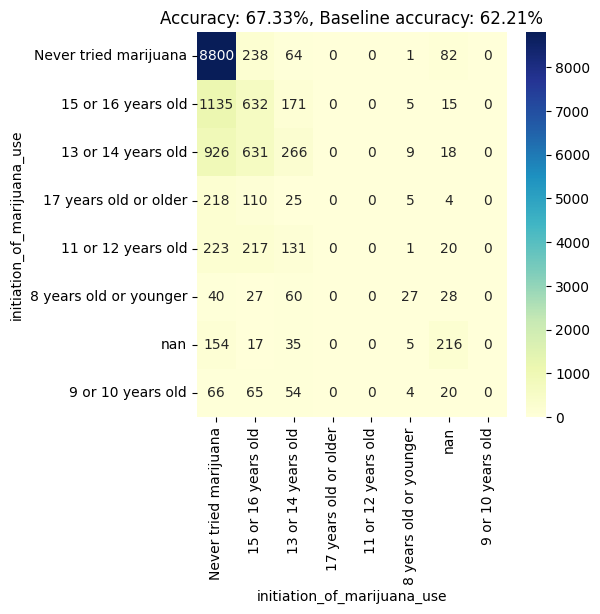

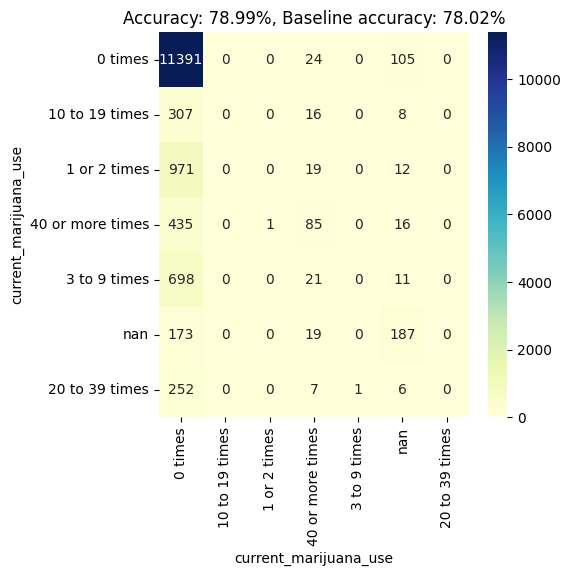

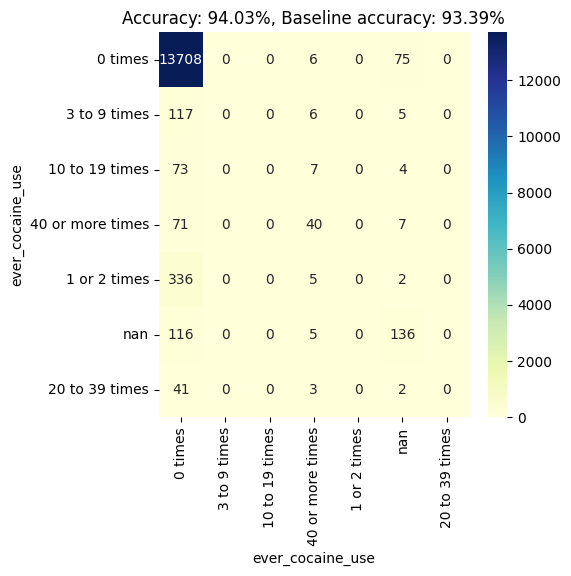

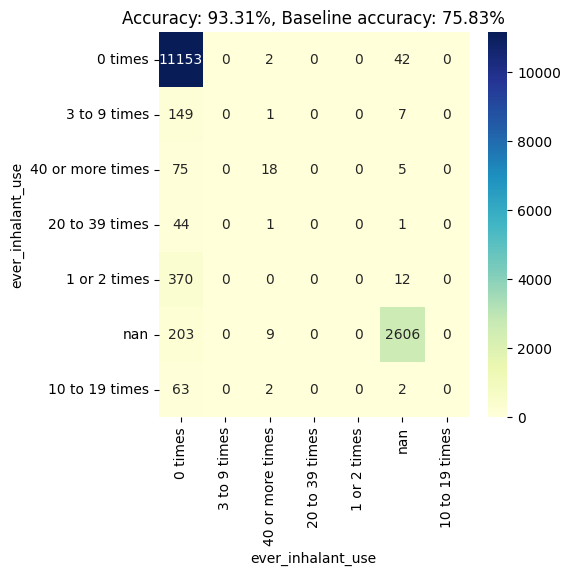

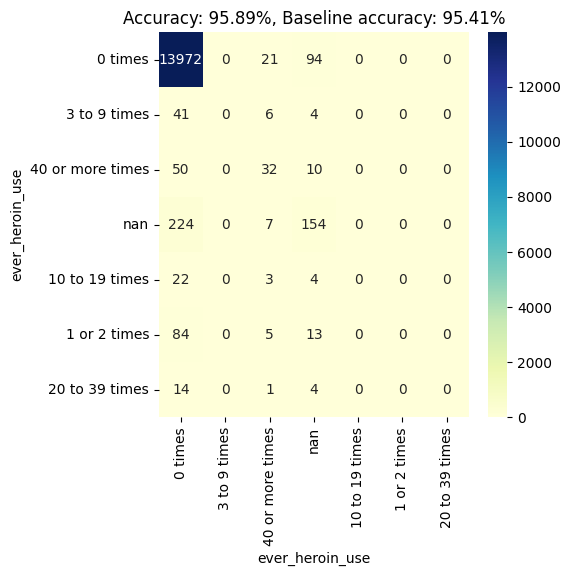

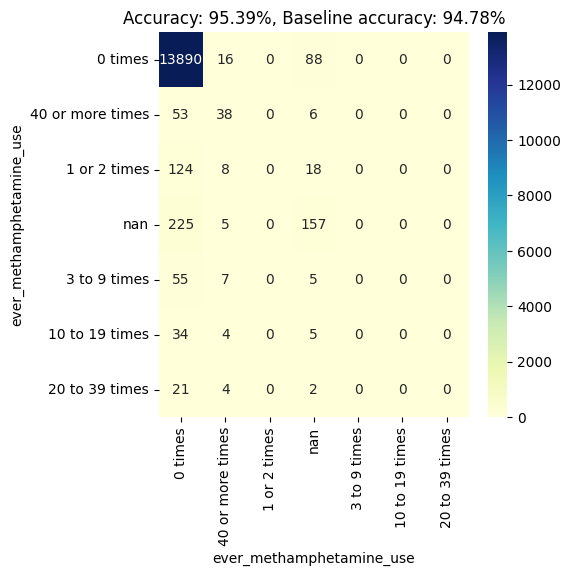

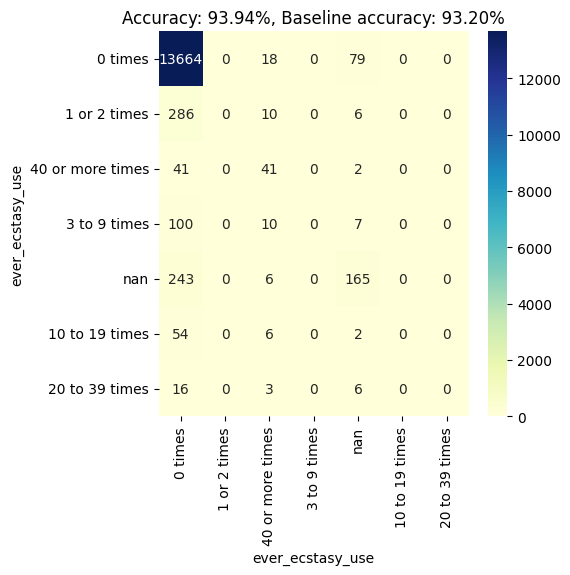

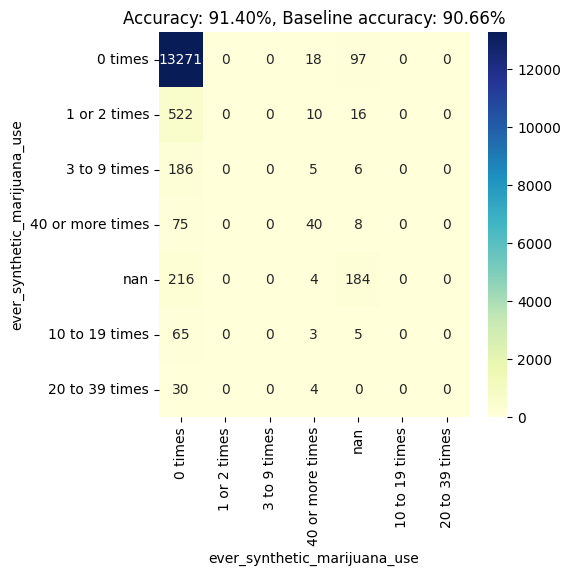

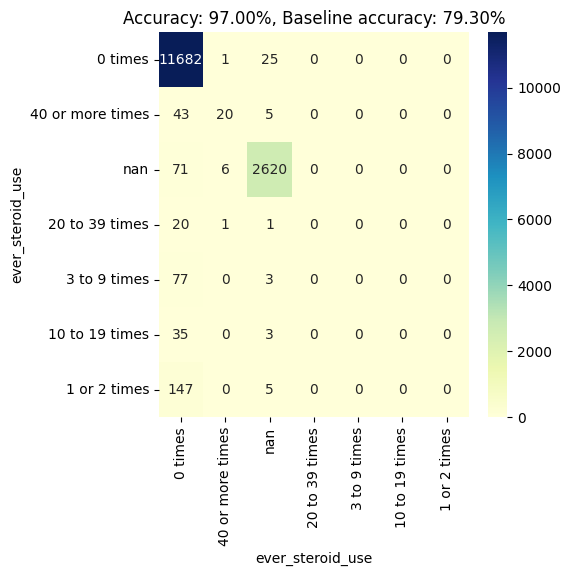

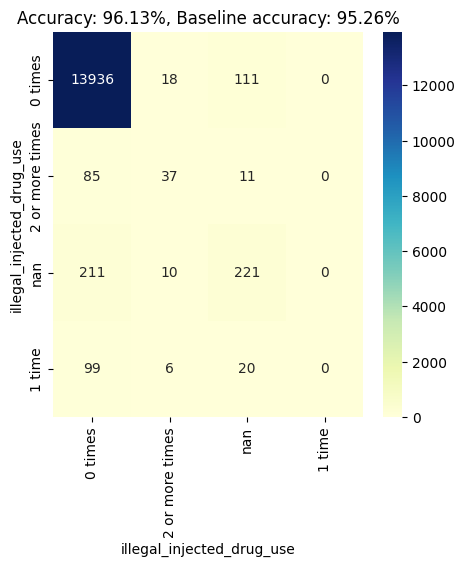

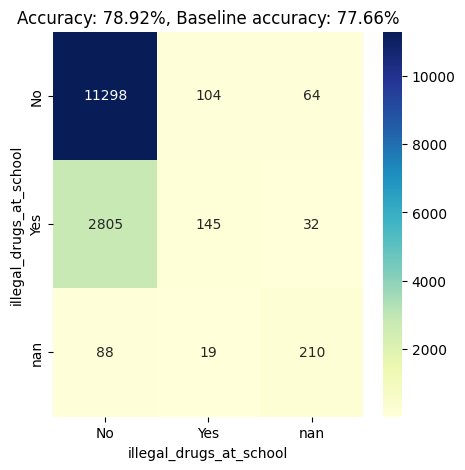

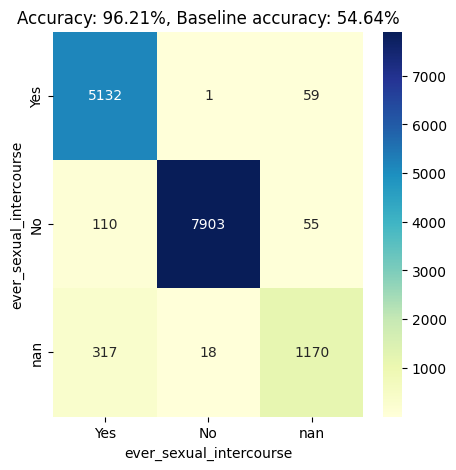

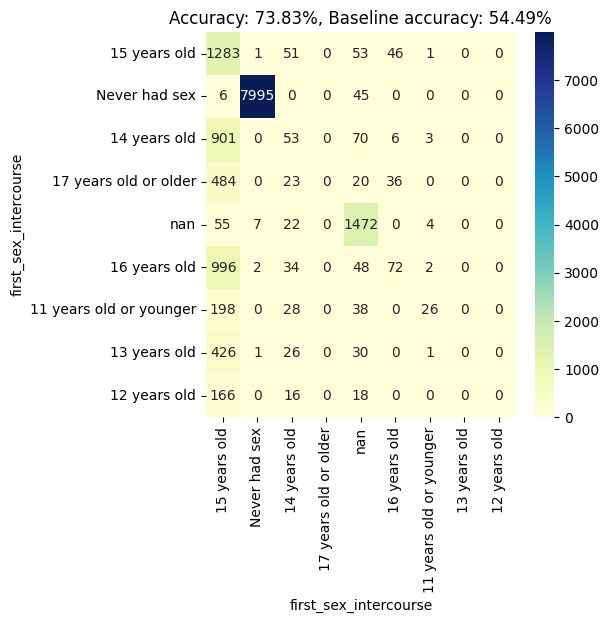

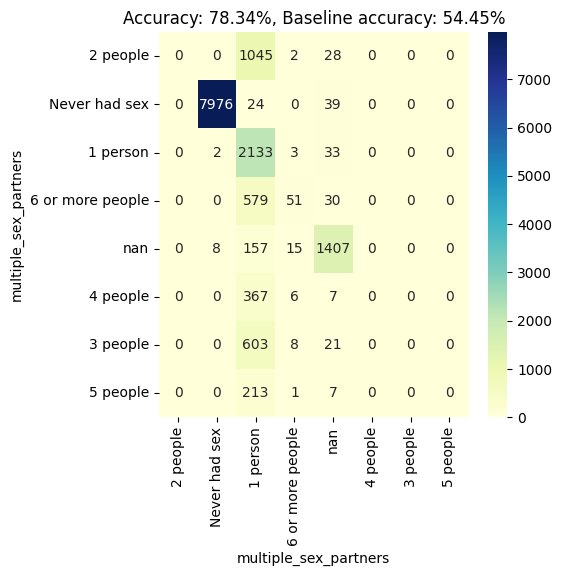

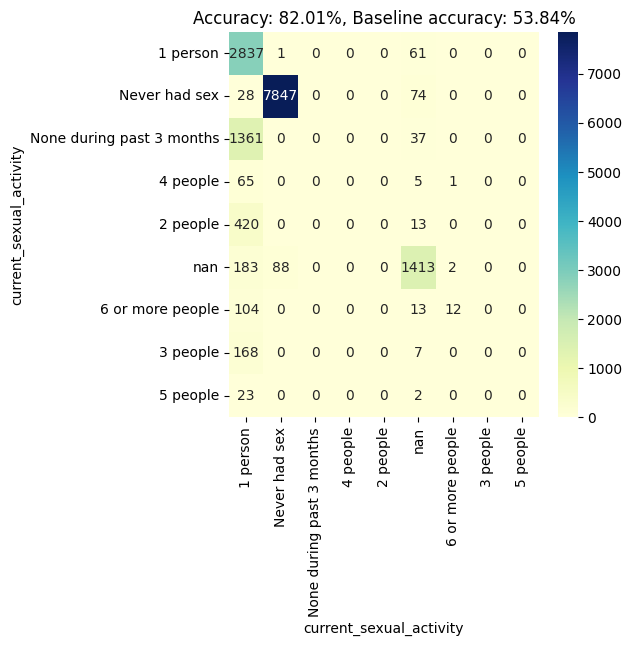

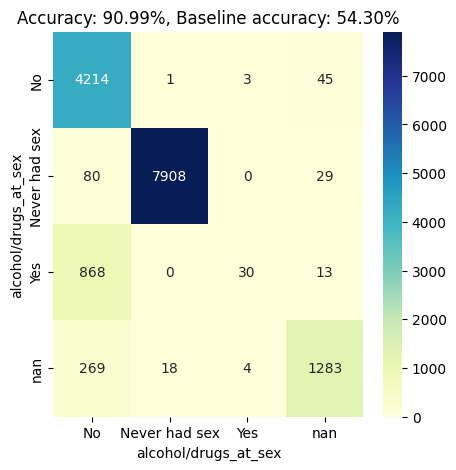

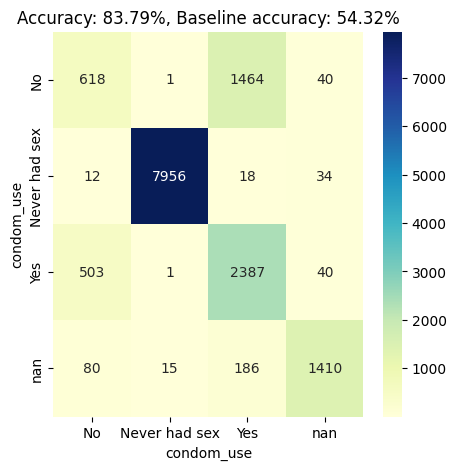

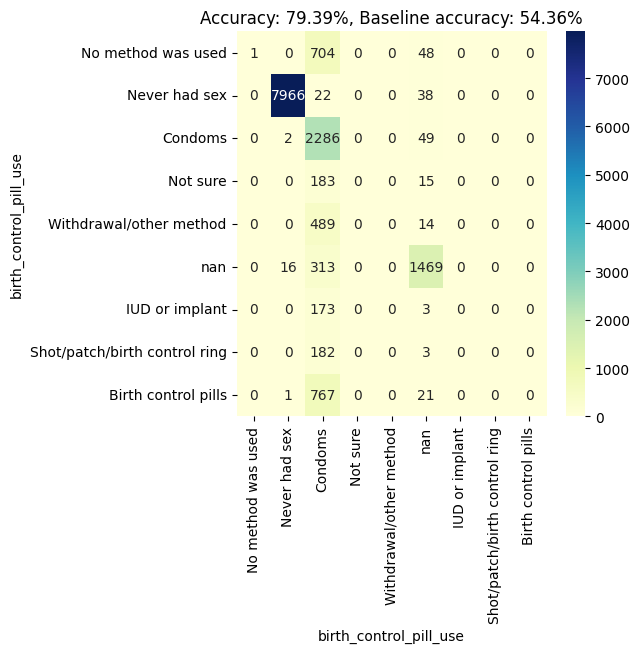

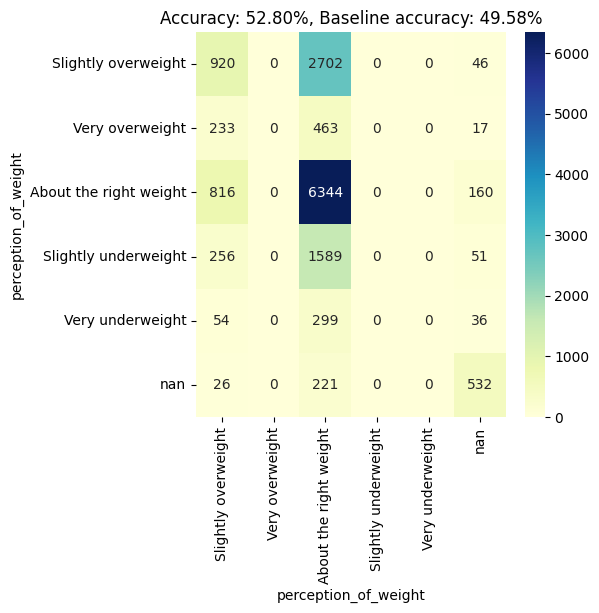

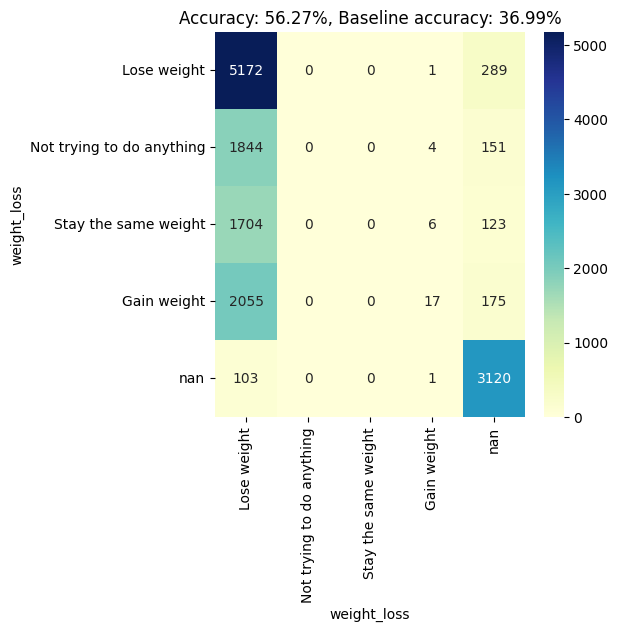

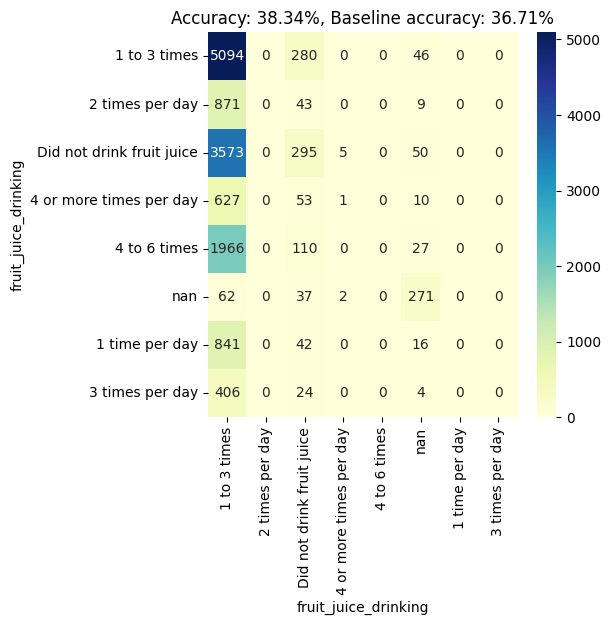

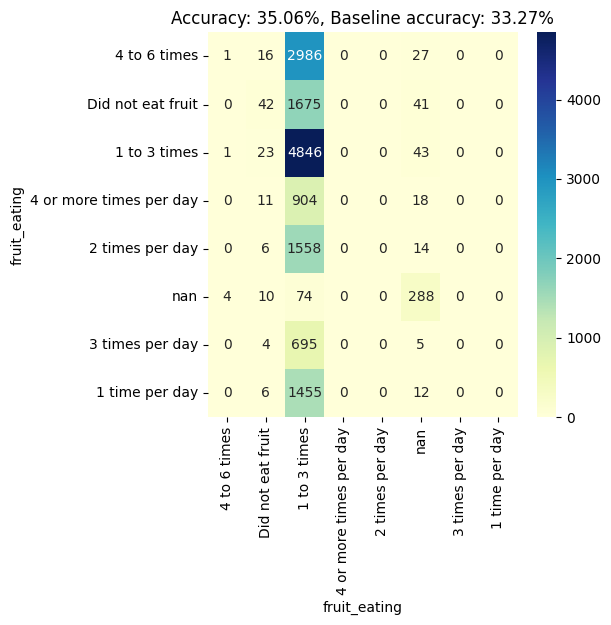

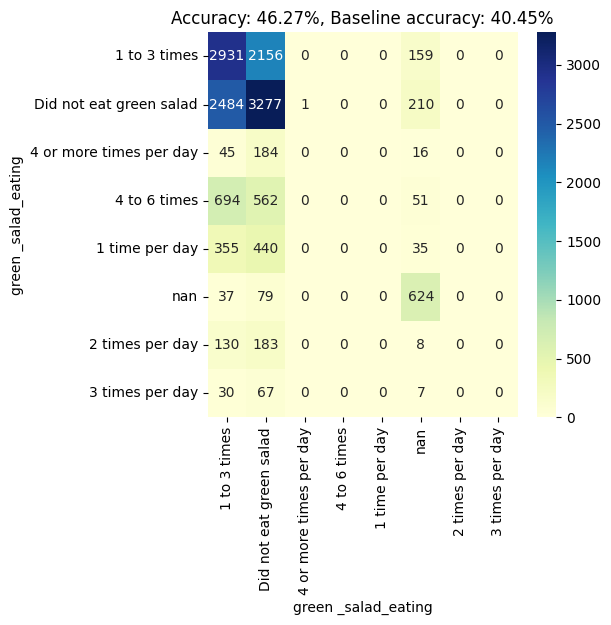

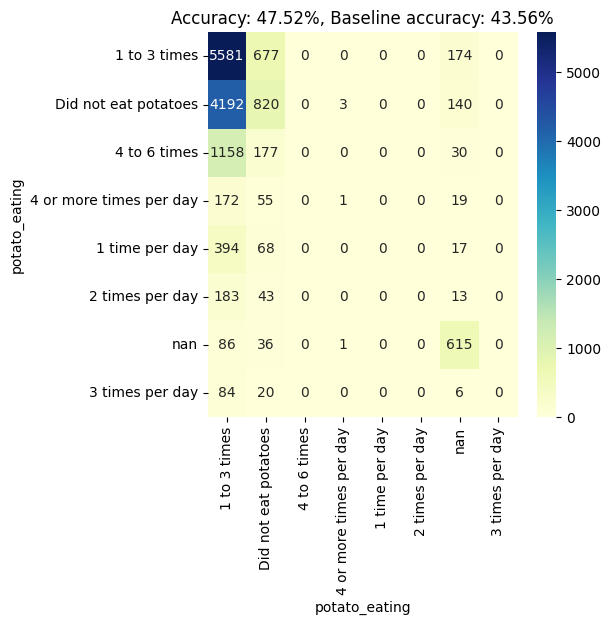

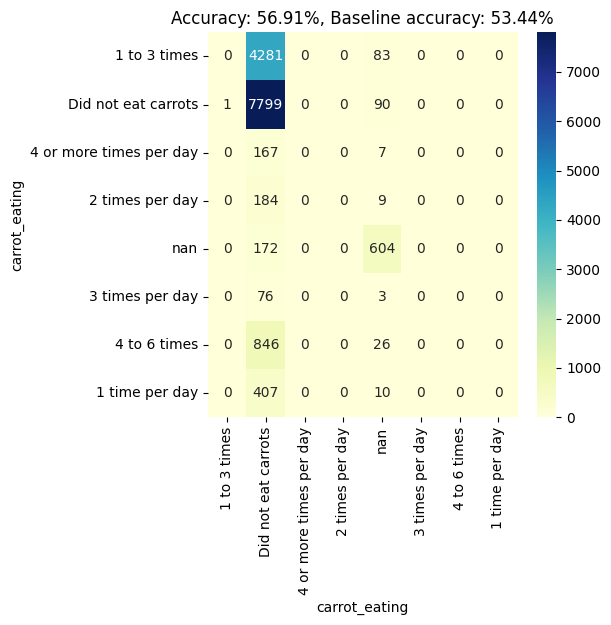

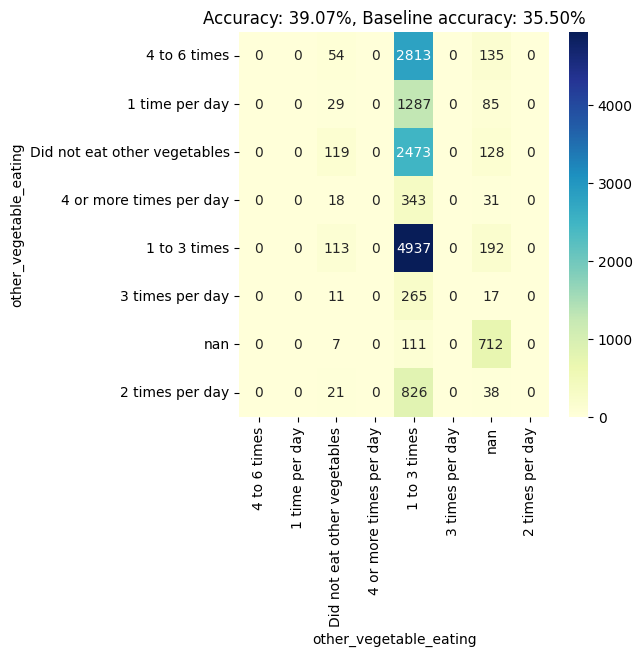

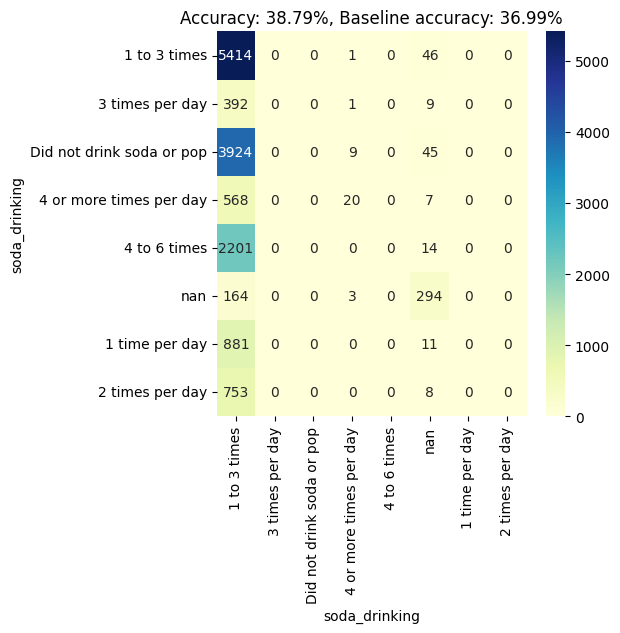

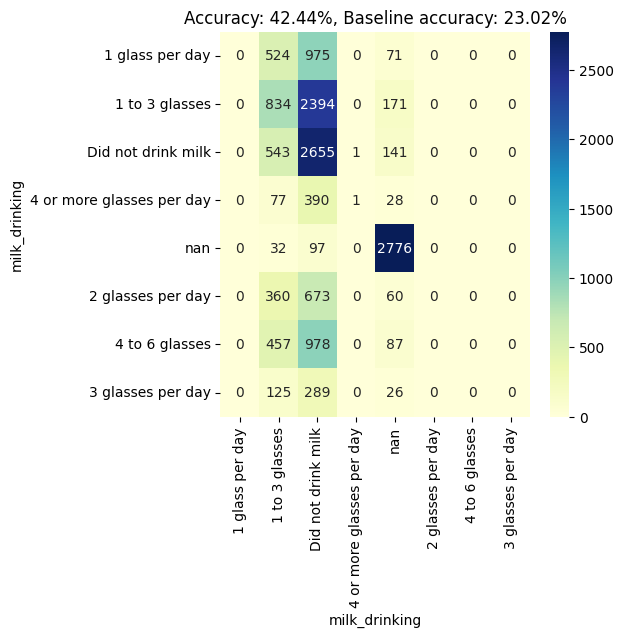

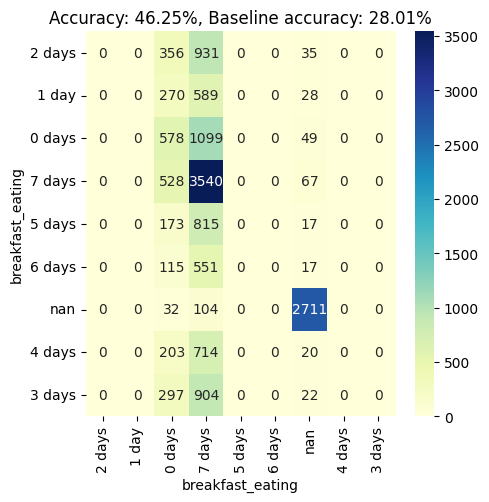

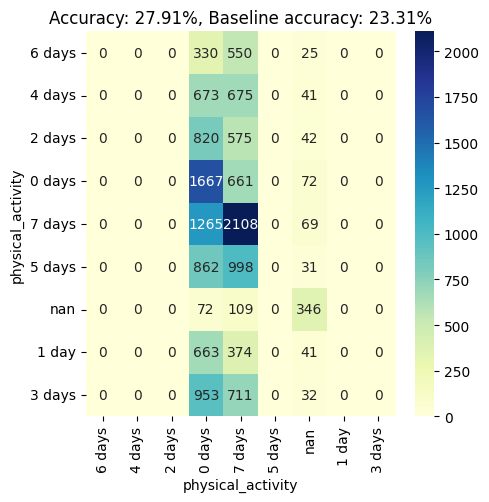

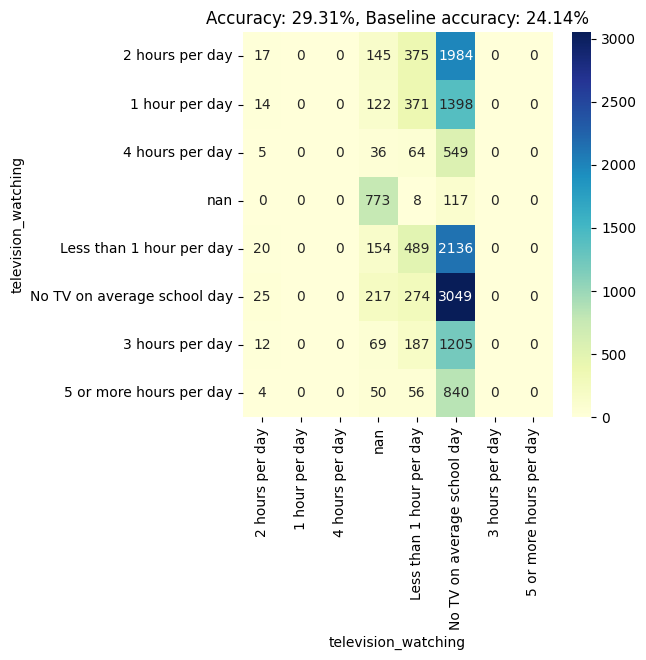

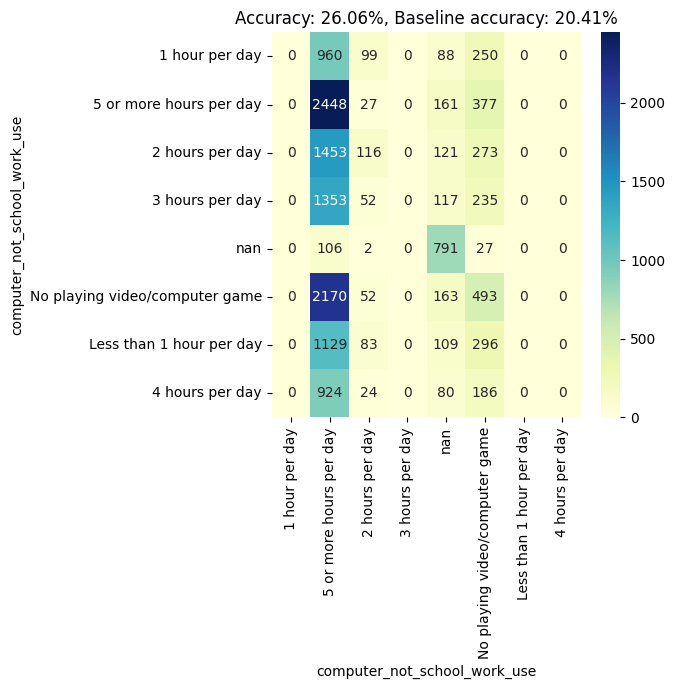

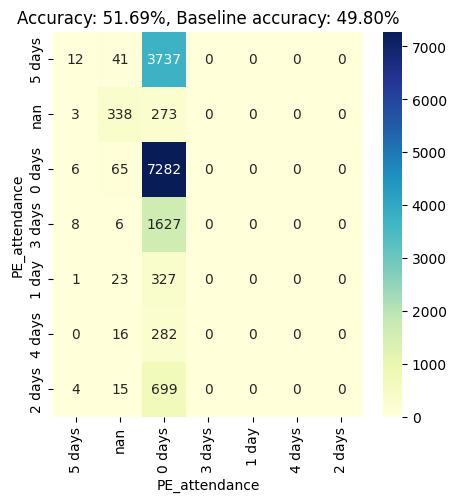

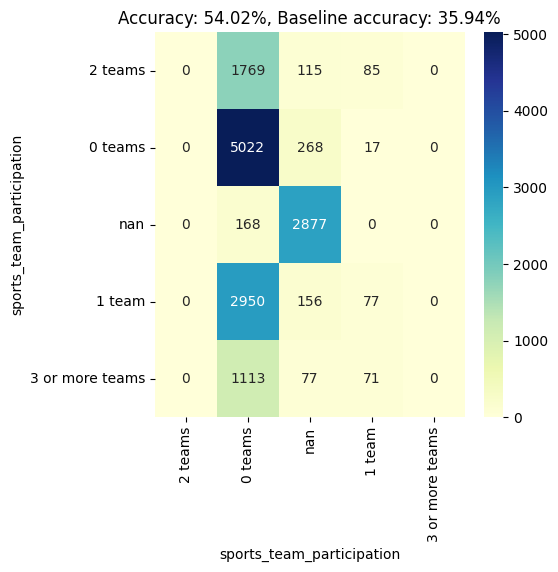

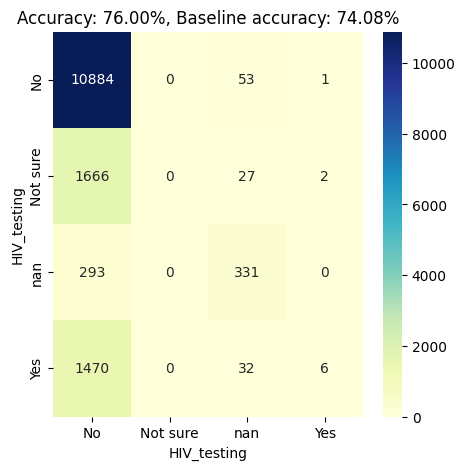

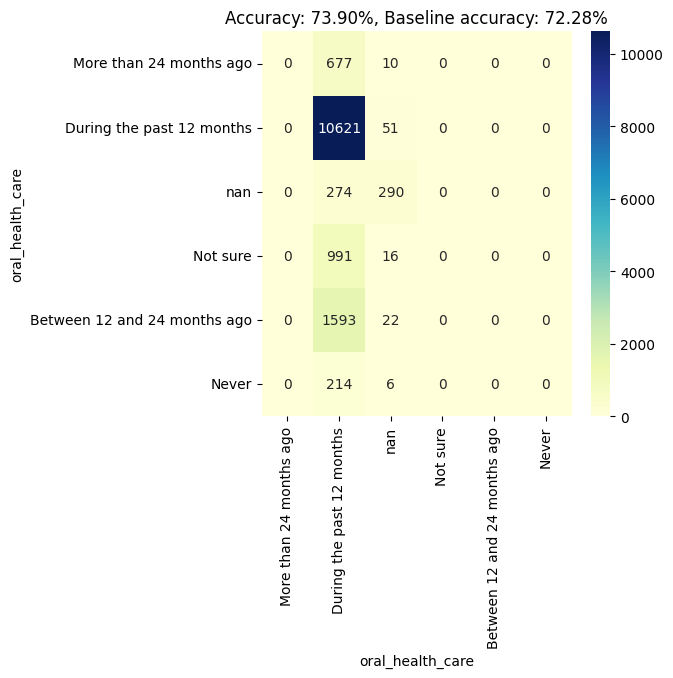

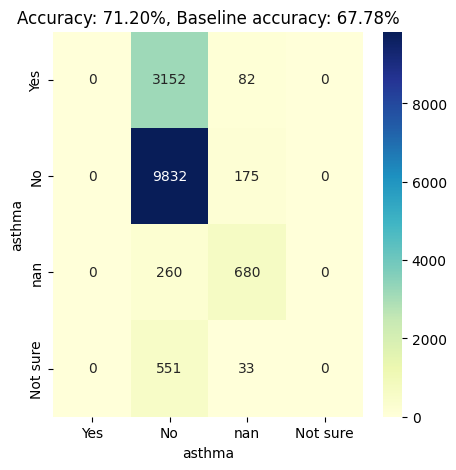

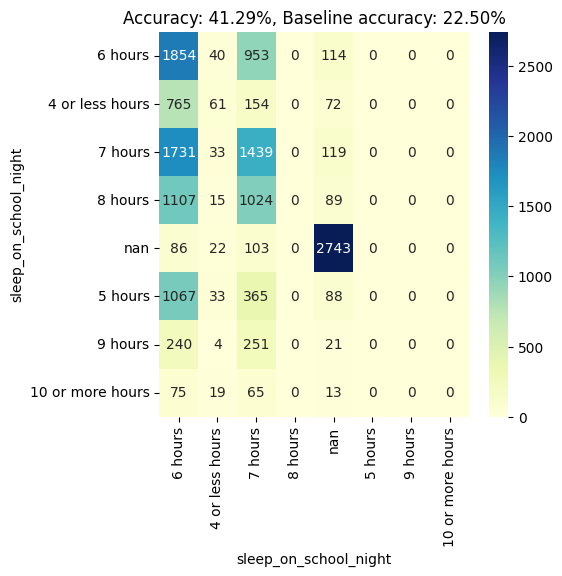

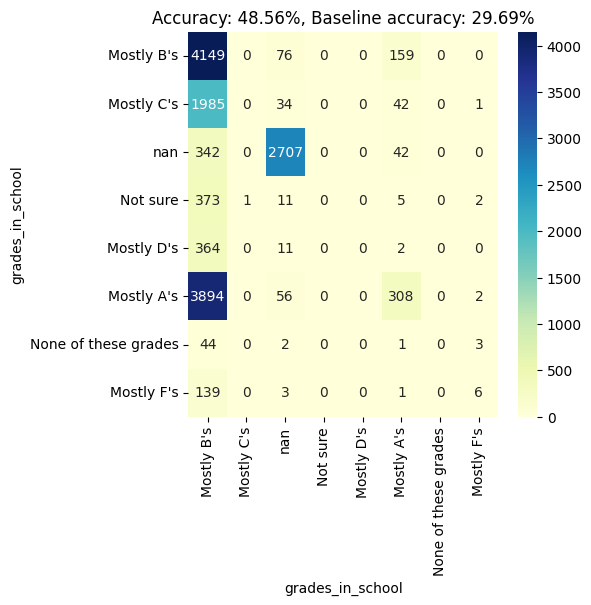

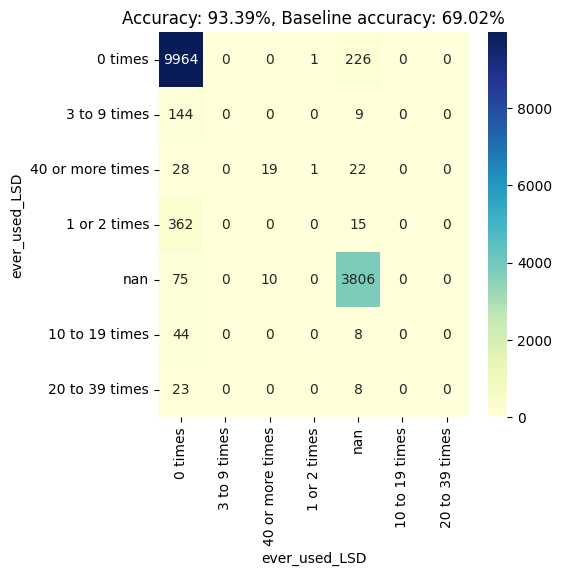

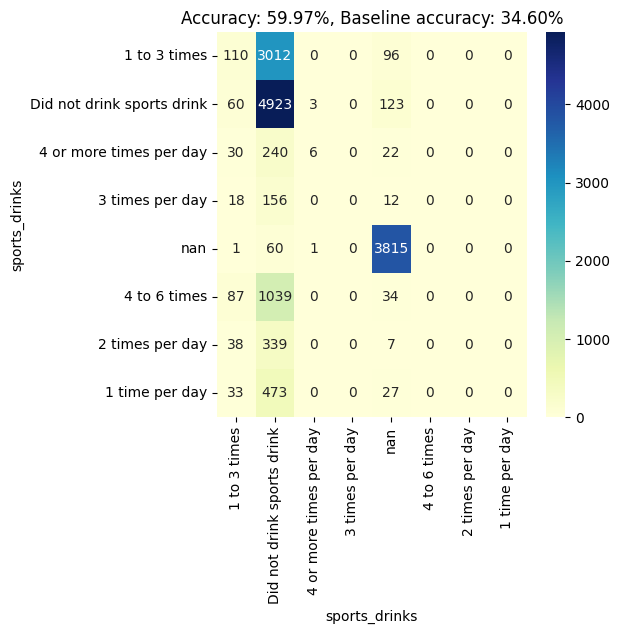

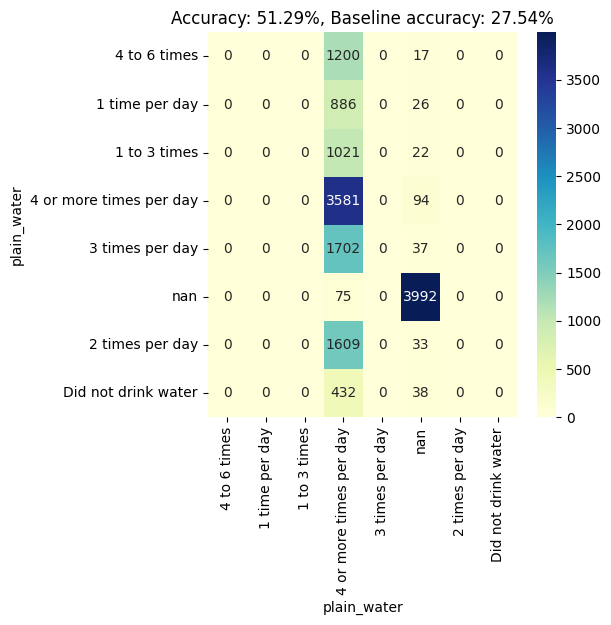

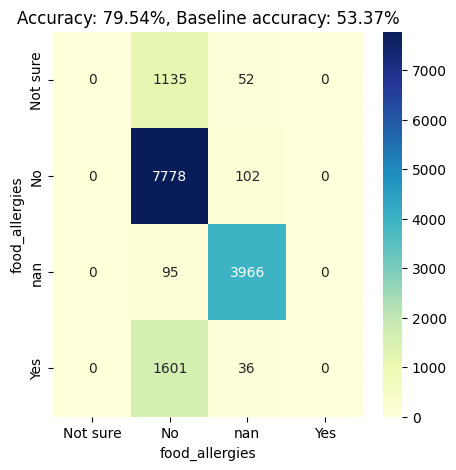

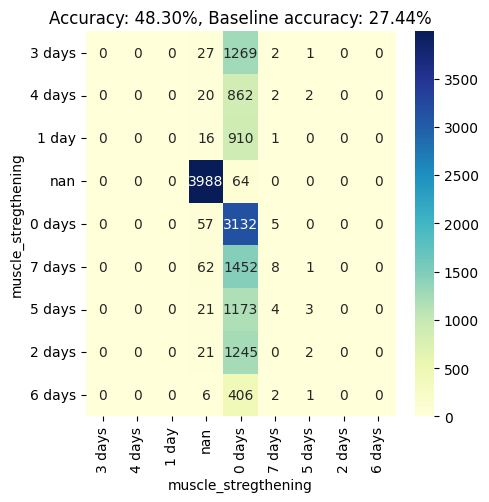

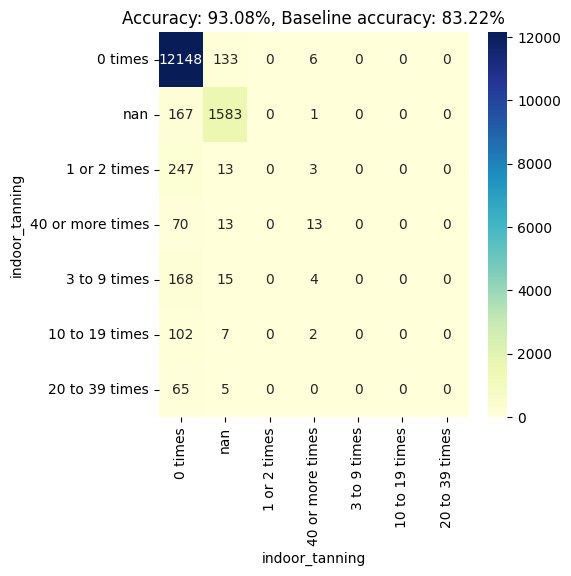

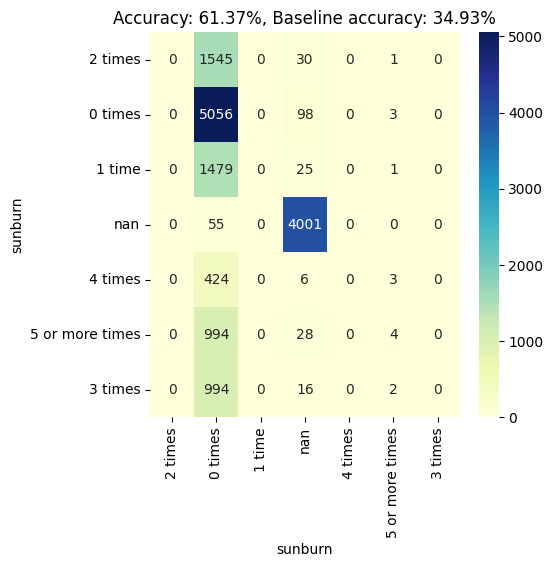

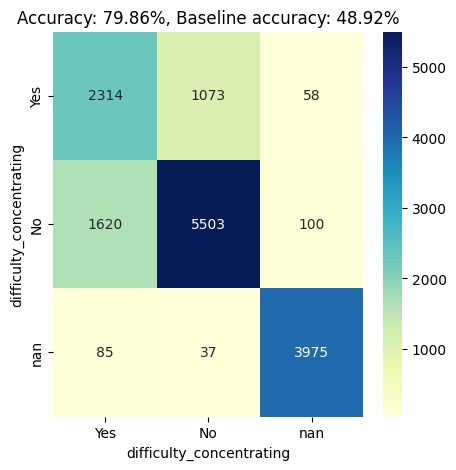

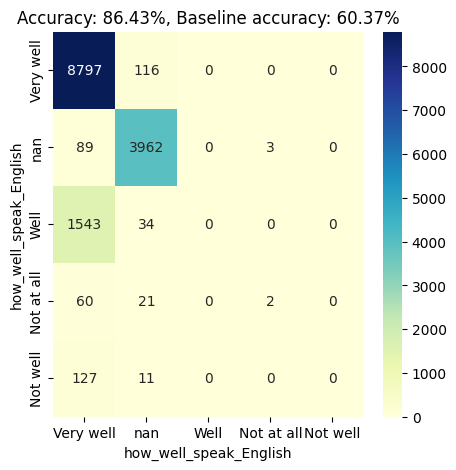

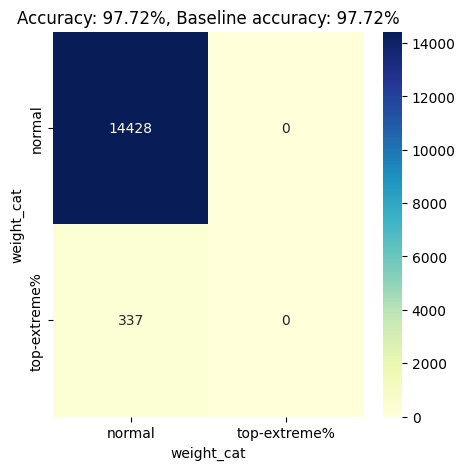

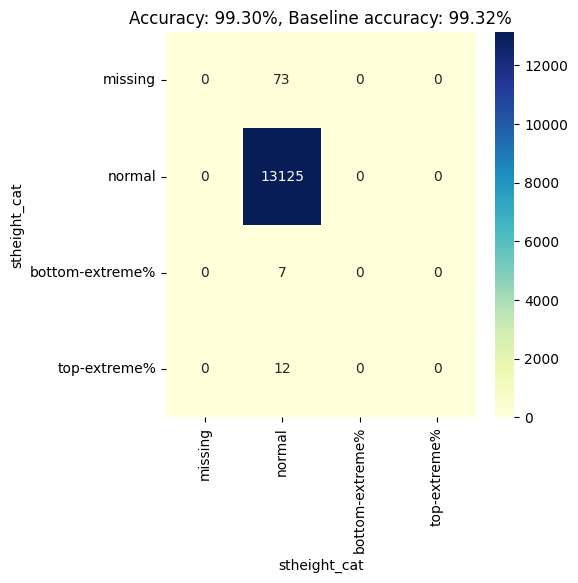

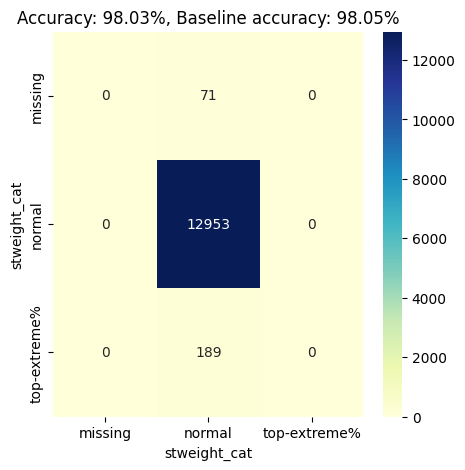

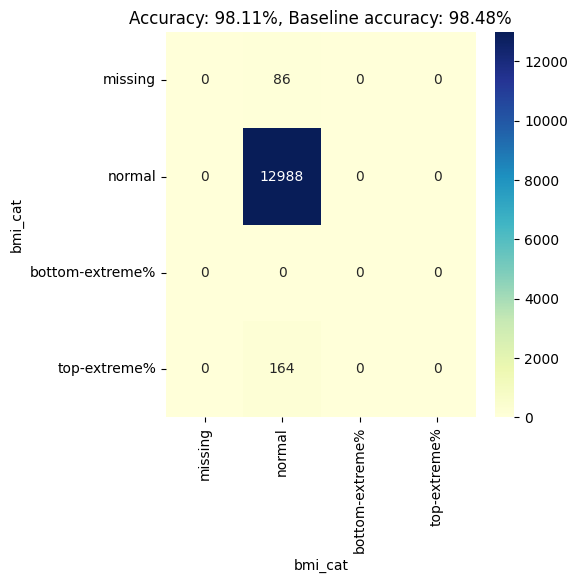

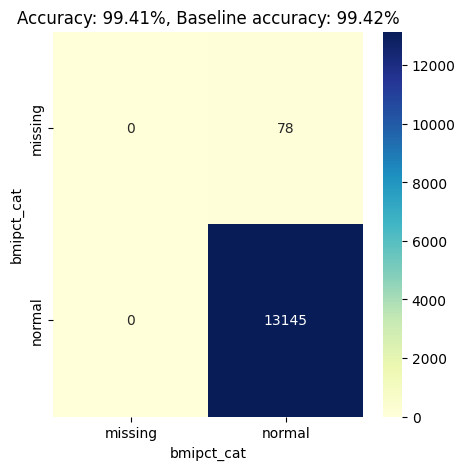

In [20]:
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def create_scatterplot_for_categorical(original_df, predicted_df, categ_attr):
    # Create a list of all unique categories present in the original data
    all_categories = original_df[categ_attr].unique()

    # Create the confusion matrix using crosstab
    confusion_matrix = pd.crosstab(original_df[categ_attr], predicted_df[categ_attr])

    # Reindex the confusion matrix to include all categories in the original data
    confusion_matrix = confusion_matrix.reindex(index=all_categories, columns=all_categories, fill_value=0)

    # Calculate accuracy
    diagonal_sum = np.trace(confusion_matrix.values)
    total_sum = np.sum(confusion_matrix.values)
    accuracy = diagonal_sum / total_sum * 100

    # Calculate baseline accuracy
    baseline_accuracy = original_df[categ_attr].value_counts().max() / total_sum * 100


    plt.figure(figsize=(5, 5))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="YlGnBu")
    plt.title(f"Accuracy: {accuracy:.2f}%, Baseline accuracy: {baseline_accuracy:.2f}%")
    plt.show()
    return accuracy, baseline_accuracy

result = []
for v in variable_types.keys():
  if variable_types[v] == 'categorical':
    # print(v)
    a,b = create_scatterplot_for_categorical(project_data, tabular_from_predicted, v)
    entry = { 'variable': v, 'accuracy': a, 'baseline_accuracy': b }
    result.append(entry)

result = pd.DataFrame(result)




In [ ]:
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.preprocessing import label_binarize

def calculate_extended_metrics(original_df, predicted_df, categ_attr):
    all_categories = original_df[categ_attr].unique()
    confusion_matrix = pd.crosstab(original_df[categ_attr], predicted_df[categ_attr])
    confusion_matrix = confusion_matrix.reindex(index=all_categories, columns=all_categories, fill_value=0)

    diagonal_sum = np.trace(confusion_matrix.values)
    total_sum = np.sum(confusion_matrix.values)

    accuracy = diagonal_sum / total_sum * 100
    baseline_accuracy = original_df[categ_attr].value_counts().max() / total_sum * 100

    # One-vs-All ROC and AUC
    y_true = label_binarize(original_df[categ_attr], classes=all_categories)
    y_pred = label_binarize(predicted_df[categ_attr], classes=all_categories)
    ova_roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovr', average='macro')

    return accuracy, baseline_accuracy, ova_roc_auc

# Example usage:
# accuracy, baseline_accuracy, ova_roc_auc = calculate_extended_metrics_without_prob(original_df, predicted_df, categ_attr)


result = []
for v in variable_types.keys():
  if variable_types[v] == 'categorical':
    print(v)
    if v.endswith("_cat"): continue # do not analyze numeric vars for now
    a,b, c = calculate_extended_metrics(project_data, tabular_from_predicted, v)
    entry = { 'variable': v, 'accuracy': round(a,1), 'baseline_accuracy': round(b,1), 'ova_auc': c, 'lift': round(a/b,2) }
    result.append(entry)

df = pd.DataFrame(result)

df['lift'].mean()



In [38]:
df.sort_values(by='ova_auc', ascending=False).head(25)

variable  accuracy  baseline_accuracy   ova_auc  lift
56       ever_sexual_intercourse      96.2               54.6  0.948227  1.76
12                      sexpart2      90.8               36.4  0.868481  2.50
91      difficulty_concentrating      79.9               48.9  0.848531  1.63
61                    condom_use      83.8               54.3  0.841511  1.54
60          alcohol/drugs_at_sex      91.0               54.3  0.837145  1.68
33            ever_cigarette_use      83.0               58.2  0.828461  1.43
11                       sexpart      90.2               36.4  0.781414  2.48
8            sex/sexual_contacts      75.4               36.6  0.777300  2.06
5                          obese      86.5               75.9  0.735218  1.14
6                     overweight      85.1               74.5  0.730367  1.14
36  electronic_vapor_product_use      76.8               56.9  0.714738  1.35
87                food_allergies      79.5               53.4  0.691841  1.49
58         multiple_sex_partners      78.3               54.4  0.667798  1.44
92        how_well_speak_English      86.4               60.4  0.666036  1.43
32     injurious_suicide_attempt      83.6               66.2  0.653949  1.26
57         first_sex_intercourse      73.8               54.5  0.652467  1.35
53              ever_steroid_use      97.0               79.3  0.652197  1.22
54     illegal_injected_drug_use      96.1               95.3  0.649063  1.01
19     safety_concerns_at_school      93.8               76.7  0.648636  1.22
28               sad_or_hopeless      71.0               67.0  0.648545  1.06
59       current_sexual_activity      82.0               53.8  0.648289  1.52
84                 ever_used_LSD      93.4               69.0  0.646587  1.35
10                        sexid2      84.5               81.4  0.646320  1.04
62        birth_control_pill_use      79.4               54.4  0.641308  1.46
29            considered_suicide      83.9               81.2  0.634270  1.03

In [39]:
df.sort_values(by=['ova_auc','baseline_accuracy'], ascending=True).head(25)

variable  accuracy  baseline_accuracy  \
27                   electronic_bullying      84.6               84.5   
26                    bullying_at_school      80.9               80.9   
14         riding_with_a_drinking_driver      83.4               83.2   
18             weapon_carrying_at_school      94.2               94.2   
23             forced_sexual_intercourse      90.3               90.3   
4                                   race      42.9               42.4   
25              physical_dating_violence      59.9               59.0   
24                sexual_dating_violence      59.3               58.3   
20                  threatened_at_school      93.4               93.2   
34                 current_cigarette_use      89.4               89.3   
37  current_electronic_vapor_product_use      76.3               75.7   
38                     current_cigar_use      90.1               90.0   
3                     Hispanic_or_Latino      43.0               42.4   
16                   texting_and_driving      43.1               38.1   
22           physical_fighting_at_school      89.4               89.2   
0                                    age      29.2               25.0   
77                         PE_attendance      51.7               49.8   
71                         soda_drinking      38.8               37.0   
80                      oral_health_care      73.9               72.3   
65                  fruit_juice_drinking      38.3               36.7   
66                          fruit_eating      35.1               33.3   
2                                  grade      34.4               26.6   
46                 current_marijuana_use      79.0               78.0   
69                         carrot_eating      56.9               53.4   
1                                    sex      58.5               51.0   

     ova_auc  lift  
27  0.501162  1.00  
26  0.501303  1.00  
14  0.504817  1.00  
18  0.505465  1.00  
23  0.507120  1.00  
4   0.510688  1.01  
25  0.510728  1.01  
24  0.512518  1.02  
20  0.512658  1.00  
34  0.513032  1.00  
37  0.516494  1.01  
38  0.516748  1.00  
3   0.518419  1.01  
16  0.518593  1.13  
22  0.523971  1.00  
0   0.533078  1.17  
77  0.542376  1.04  
71  0.543577  1.05  
80  0.548838  1.02  
65  0.549113  1.04  
66  0.550651  1.05  
2   0.552371  1.30  
46  0.553425  1.01  
69  0.553647  1.07  
1   0.555631  1.15

In [ ]:
df.plot(x='baseline_accuracy', y='lift', kind='scatter')
plt.show()